<div style="border:solid Green 2px; border-radius: 10px;  padding: 40px">
<b>Привет, Георгий!👋</b>
    
Меня зовут Зуева Юлия, можно просто Юля 😏 Я буду ревьюером твоего проекта. Предлагаю обращаться на "ты", но если это неудобно, пожалуйста, скажи об этом! 
    
Моя основная цель - помочь тебе стать компетентным Data Scientist'ом: вместе преодолеть трудности и еще больше развить твои сильные навыки 💪 В твоей работе я оставила комментарии, которые должны в этом помочь. Для твоего удобства комментарии расскрашены разными цветами: 
<br/>
<div style="border-radius: 10px" class="alert alert-success">
<b>Отлично ✅:</b> В случае корректного решения (или отдельных его моментов). На такие решения можно опираться в будущем.
</div>
<div style="border-radius: 10px" class="alert alert-warning">
<b>Рекомендации💡:</b> Если есть возможность как-либо улучшить решение. Ты можешь учесть эти комментарии при доработке проекта, однако для зачета это не обязательно.
</div>
<div style="border-radius: 10px" class="alert alert-block alert-danger">
<b>Нужно доработать ❌:</b> Если решение требует внесения правок. Проект не может быть принят, если остались не отработанные комментарии данного типа.
</div>
<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
</div>    
Чтобы наша с тобой работа была еще эффективнее, ты точно так же можешь оставлять комментарии и задавать мне вопросы. Для таких случаев, пожалуйста, выбери собственное оформление комментариев, которое будет отличаться от моего, чтобы не создавалась путаница. По этой же причине попрошу тебя не удалять и не изменять мои комментарии. Все это позволит лучше ориентироваться в нашем с тобой диалоге, а повторную проверку (в случае ее необходимости) выполнять оперативнее 🚀
    
Не спеши расстраиваться, если что-то не удалось с первого раза. Вместе мы обязательно разберемся со всеми трудностями! 🤓

# Анализ лояльности пользователей Яндекс Афиши

<div style="border:solid #D3D3D3 2px; border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Вводная часть <a class="tocSkip"></h4>

<div style="border-radius: 10px" class="alert alert-warning">
<b>Рекомендации💡:</b> В любой работе важно оставлять вводную часть. Она помогает быстро понять цель, контекст и структуру работы, что будет удобно не только для тебя при возвращении к проекту спустя время, но и любому другому читателю (если, например, публикуешь в открытый доступ для портфолио). Воспринимаем эту тетрадку не просто как выполнение домашней работы на курсе, а как полноценный исследовательский проект.

Как правило, в вводную часть включают название проекта, краткое описание цели, используемых данных (источники, объем, особенности), нюансы самого проекта (специфические условия, ограничения, предположения и т.д.). Иногда также сразу обозначают план шагов. Другими словами, вводная часть призвана отразить, что мы делаем, с чем работаем и на каких условиях.
</div>

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1]:
# Используйте ячейки типа Code для вашего кода,
# а ячейки типа Markdown для комментариев и выводов

In [2]:
# При необходимости добавляйте новые ячейки для кода или текста

In [3]:
import sys
!{sys.executable} -m pip install sqlalchemy psycopg2-binary pandas -q
import pandas as pd
from sqlalchemy import create_engine

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML, Markdown, Image
# Загружаем библиотеку для расчёта коэффициента корреляции phi_k
try:
    from phik import phik_matrix
except ImportError:
    !pip install phik
    from phik import phik_matrix
    
import os
from dotenv import load_dotenv
import datetime

# Загружаем переменные из .env
load_dotenv()

# Проверяем, что все переменные загружены
required_vars = ['DB_USER', 'DB_PASSWORD', 'DB_HOST', 'DB_PORT', 'DB_NAME']
for var in required_vars:
    if not os.getenv(var):
        raise ValueError(f"Переменная {var} не найдена в .env файле")

# Формирование строки подключения из переменных окружения
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    os.getenv('DB_USER'),
    os.getenv('DB_PASSWORD'),
    os.getenv('DB_HOST'),
    os.getenv('DB_PORT'),
    os.getenv('DB_NAME')
)


engine = create_engine(connection_string)


query = '''
-- Настройка параметра synchronize_seqscans важна для проверки
WITH set_config_precode AS (
  SELECT set_config('synchronize_seqscans', 'off', true)
)

SELECT
  p.user_id,
  p.device_type_canonical,
  p.order_id,
  p.created_dt_msk AS order_dt,
  p.created_ts_msk AS order_ts,
  p.currency_code,
  p.revenue,
  p.tickets_count,
  CASE
    WHEN LAG(p.created_dt_msk) OVER (PARTITION BY p.user_id ORDER BY p.created_dt_msk) IS NULL THEN NULL
    ELSE EXTRACT(DAY FROM (p.created_dt_msk - LAG(p.created_dt_msk) OVER (PARTITION BY p.user_id ORDER BY p.created_dt_msk)))
  END AS days_since_prev,
  p.event_id,
  e.event_name_code AS event_name,
  e.event_type_main,
  p.service_name,
  r.region_name,
  c.city_name
FROM afisha.purchases p
LEFT JOIN afisha.events e ON p.event_id = e.event_id
LEFT JOIN afisha.city c ON e.city_id = c.city_id
LEFT JOIN afisha.regions r ON c.region_id = r.region_id
WHERE p.device_type_canonical IN ('mobile', 'desktop')
  AND e.event_type_main != 'фильм'
ORDER BY p.user_id
'''

# 7. Выполнение запроса и загрузка в DataFrame
df = pd.read_sql_query(query, con=engine)

# 8. Просмотр результата
print(f'Размер датафрейма: {df.shape}')
print('\nПервые строки данных:')
display(df.head())

You should consider upgrading via the 'C:\Users\User\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Размер датафрейма: (290611, 15)

Первые строки данных:


,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


**Подключение прошло успешно, SQL запрос сработал**

<div style="border:solid #D3D3D3 2px; border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Импорты <a class="tocSkip"></h4>

<div style="border-radius: 10px" class="alert alert-warning">
<b>Рекомендации💡:</b> 
    
* Перед отправкой проекта / публикацией важно сбрасывать ядро (очищать память от созданных объектов) и заново запускать проект с самого начала, чтобы проверить на наличие ошибок в коде при последовательном исполнении ячеек. Сейчас этого сделано не было, нумерация ячеек начинается не с 1 и идет непоследовательно.
    
    
* Чтобы при установке новой библиотеки не выводилась информация о процессе и зависимостях, можно добывлять опцию `--quiet` или просто `-q`. 
    
    
* Все необходимые библиотеки лучше подгружаешь сразу в начале проекта, это соответсвует стандартам оформления кода <a href='https://pyplanet.ru/article/pep-0008.html'>PEP 8</a>. Такой подход позволяет сразу видеть, какое окружение необходимо для запуска проекта, избежать дублирования импортов в разных частях кода, а также облегчить отладку и переносимость проекта. 
    
    
* Хорошей практикой также является упорядочивание импортов. PEP 8 рекомендует снчала подгружать стандартные python-библиотеки, затем сторонние. Но для удобства каждую их этих групп также можно стуктурировать по тематике. Например, библиотеки для работы с данными, для работы с графиками и т.д. Тогда будет удобнее поддерживать порядок в импортах от проекта к проекту, не подгружать лишнее.
    
 
* Импортирование библиотек и подгрузка данных - это все-таки отдельные шали, поэтому их лучше разделить.
    
</div>
    
<h4> Загрузка данных <a class="tocSkip"></h4>
<div style="border-radius: 10px" class="alert alert-success">
<b>Отлично ✅:</b> Выгрузка данных проведена корректно! Была выполнена необходимая фильтрация данных, выгружены только необходимые для анализа данные. Отлично, что сразу подсчитываешь время между заказами для каждого пользователя.
 
</div>
<div style="border-radius: 10px" class="alert alert-block alert-danger">
    
<b>Нужно доработать ❌:</b> Сейчас ты явным образом прописываешь параметры подключения к БД. В таком виде выкладывать работу в публичный доступ небезопасно, кто-то сможет завладеть подключением, украсть или повредить данные. Лучше сразу в процессе работы держать чувствиительные значения отдельно от основного содержания, иначе есть высокий риск забыть об этом нюансе. **По этой же причине нужно убрать ключи и из описания задания.**
    
Чтобы засекретить подключение, необходимо сложить все параметры в `.env` файл (или другой конфигурационный файл вне Git) и указать его в `.gitignore`:

```python
DB_NAME="..."
DB_HOST="..."
DB_PORT="..."
DB_USER="..."
DB_PASSWORD="..."
```
    
В самом проекте мы можем обращаться к сохраненным параметрам, для этого нам потребуются библиотеки `dotenv`, чтобы загрузить переменные окружения, и `os`, чтобы обратиться к ним:
    
```python
import os
import dotenv
    
load_dotenv() # автоматически ищет .env в текущей директории
    
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    os.getenv('DB_USER'),
    os.getenv('DB_PASSWORD'),
    os.getenv('DB_HOST'),
    os.getenv('DB_PORT'),
    os.getenv('DB_NAME'),
) 
```
</div>
<div class="alert alert-info">
<b>Комментарий студента:</b> испарвил подключение (до этого работал в среде Прктикума. Теперь перешёл на локальный JupyterNotebook)
<br>
</div>   

<div style="border-radius: 10px" class="alert alert-warning">

<b>Рекомендации💡:</b> `print` используется для простого текстового вывода. Но в средах с поддержкой rich output (Jupyter, IPython) также доступен `display`. Для объектов, где важно сохранить форматирование или визуализацию (DataFrame, картинки, графики, HTML и т.д.) лучше использовать его.   
</div>

<div class="alert alert-info">
<b>Комментарий студента:</b> спасибо, буду по возможность использовать display
<br>
</div>   

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

На основе информации мы видим что в таблице:  
**290611 строк**  
**15 столбцов**  
Типы данных у всех столбцов - корректны.
Можно откорректировать битрейт некоторых столбцов по типу float64 & int64  

В дальнейшем нужно проверить правда ли days_since_prev все ли пропуски соответвствую описанию -
**"days_since_prev — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено"**

<div style="border:solid #D3D3D3 2px; border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Проверка корректности загруженных данных <a class="tocSkip"></h4>
<div style="border-radius: 10px" class="alert alert-success">
<b>Отлично ✅:</b> 

* Хорошо, что убеждаешь в корректности данных! Если при подгрузке возникли проблемы, а мы их не обнаружим, все последующие расчеты могут быть искажены.

    
* Круто, что не забываешь зафиксировать промежуточные наблюдения в выводах! Если потребуется вернуться к проекту спустя время, будет проще освежить в памяти все ключевые этапы работы, что и почему мы делали, что получили.

</div>
<div style="border-radius: 10px" class="alert alert-warning">
<b>Рекомендации💡:</b> 
    
    
* Было бы не лишним пояснить, почему в `days_since_prev` могут наблюдаться пропуски, проблема ли это, или это нормальная ситауция. В нашем случае, скорее всего, пропуски образовались только на первых заказах пользователей, в таком случае у них не существует предыдущего, от которого можно было бы посчитать количество дней.
    
    
* По результатам проверки корректности загруженных данных мы планируем дальнейшие шаги по обработке. Здесь можно было отметить, что нам также потребуется убедиться, что пропуски действительно имеются только у первых заказов, выполнить проверку на дубликаты (полных и неполных), проверить категориальные столбцы на предмет неявных дубликатов (разный регистр, разный формат записи, опечатки) и все числовые столбцы на наличие невалидных значений и аномалий, опционально сменить типы данных на более оптимальные, чтобы уменьшить тяжесть данных.
 
</div>

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [5]:
df_kzt = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

# Проверяем данные курсов
print("Курсы валют:")
display(df_kzt.head())
print(f"Количество дат с курсами: {len(df_kzt)}")
print(f"Дубликаты дат: {df_kzt['data'].duplicated().sum()}")
print(f"Диапазон дат: {df_kzt['data'].min()} - {df_kzt['data'].max()}")

Курсы валют:


,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


Количество дат с курсами: 357
Дубликаты дат: 0
Диапазон дат: 2024-01-10 - 2024-12-31


In [6]:
# Загрузка курсов валют
df_kzt = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

# Подготовка дат
df_kzt['date'] = pd.to_datetime(df_kzt['data']).dt.date
df['order_date'] = df['order_dt'].dt.date

# Объединение с курсами
df = df.merge(
    df_kzt[['date', 'curs']], 
    left_on='order_date',
    right_on='date',
    how='left'
)

# Конвертация выручки в рубли
df['revenue_rub'] = df.apply(
    lambda row: row['revenue'] if row['currency_code'] == 'rub' 
    else row['revenue'] * row['curs'] / 100,
    axis=1
)

# Удаление временных столбцов
df = df.drop(['order_date', 'date'], axis=1)

# Проверка результата
print("Выручка конвертирована в рубли")
print("\nKZT заказы:")
display(df[df['currency_code'] == 'kzt'][['currency_code', 'revenue', 'revenue_rub']].head())

print("\nRUB заказы:")
display(df[df['currency_code'] == 'rub'][['currency_code', 'revenue', 'revenue_rub']].head())

Выручка конвертирована в рубли

KZT заказы:


,currency_code,revenue,revenue_rub
70,kzt,518.10,98.503762
89,kzt,347.18,65.731589
96,kzt,328.77,61.148261
277,kzt,22021.55,4380.702898
460,kzt,7397.66,1478.296591



RUB заказы:


,currency_code,revenue,revenue_rub
0,rub,1521.94,1521.94
1,rub,289.45,289.45
2,rub,1258.57,1258.57
3,rub,8.49,8.49
4,rub,1390.41,1390.41


<div style="border:solid #D3D3D3 2px;  border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Перевод выручки в рубли <a class="tocSkip"></h4>

<div style="border-radius: 10px" class="alert alert-block alert-danger">
    
<b>Нужно доработать ❌:</b> 
    
* Шаг не выполнен. Нам необходимо, используя курс, который представлен в таблице, которую ты здесь подгружаешь, привести к единой валюте выручку в нашей основной таблице с заказами, чтобы можно было ее анализировать и проводить расчеты.
    
    
* Курс представлен на 100 тенге. Если мы домножим его на 100, то представленный курс будет приходиться на 10 тысяч тенге. А нам нужно понять, сколько стоит 1 тенге.
    
</div>
    
<div style="border-radius: 10px" class="alert alert-warning">
<b>Рекомендации💡:</b> 
    
* Сперва следует убедиться в корректности данных с курсом, по всем ли датам есть курс, адекватные ли там значения, нет ли дубликатов, а уже потом переходить к конвертации.
    

* Вместо цикличного `apply`, который за раз работает с одной строкой, можно использовать довольно удобный метод [where](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.where.html). Мы можем присоединить курс к нашей таблице с пользователями, применить данный метод к столбцу с выручкой и указать условие, которое будем проверять, а также альтернативный вариант значения. Если условие выполняется, то берется значение из столбца, если нет - альтернативное значение. Тогда расчет выручки в рублях будет выглядеть следующим образом:
    
    ```python
df['revenue_rub'] = df['revenue'].where(df['currency_code'] == 'rub', df['revenue'] * df['curs'] / 100)
```
    
* После проведения каких-либо манипуляций с данными необходимо убеждаться, что все выполнилось корректно. Для проверки результата стоит вывести на обозрение только связанные с данной задачей столбцы, чтобы не перегружать читателя лишним. При этом отобразить не первые 5 строк, в которую попали только исходно рублевые наблюдения, а проверить оба кейса, и когда корректировка требовалась, и когда нет. 
    
    
* Обрати внимание, что если не ограничивать количество выводимой информации, то вывод ограничится только при отображении, но в json (в виде которых хранятся jupyter-ноутбуки) на диске будут все данные, что будет тормозить открытие и работу тетрадки. Чтобы такого не происходило, следует ограничивать вывод несколькими строками: `head`, `tail`, `sample`.
    
    
* Напоминаю про моменты, которые уже поясняла в предыдущик комментариях: использование `print` и `display`.

</div>

<div class="alert alert-info">
<b>Комментарий студента:</b> Исправил замечания
<br>
</div>  

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [7]:
print(df.isna().sum())

print(f"Пропуски только в days_since_prev: {df['days_since_prev'].isna().sum()}")
print(f"Других пропусков нет: {df.drop('days_since_prev', axis=1).isna().sum().sum() == 0}")

first_orders = df.groupby('user_id')['order_dt'].rank(method='first') == 1
print(f"Первых заказов: {first_orders.sum()}")
print(f"Пропуски = первым заказам: {df['days_since_prev'].isna().sum() == first_orders.sum()}")

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
event_name                   0
event_type_main              0
service_name                 0
region_name                  0
city_name                    0
curs                         0
revenue_rub                  0
dtype: int64
Пропуски только в days_since_prev: 21933
Других пропусков нет: True
Первых заказов: 21933
Пропуски = первым заказам: True


Всё правильно, пропуски только в столбце **days_since_prev** у первых заказов

In [8]:

for column in ['order_id', 'tickets_count', 'event_id']:
    df[column] = pd.to_numeric(df[column], downcast='integer')
for column in ['revenue', 'days_since_prev']:
    df[column] = pd.to_numeric(df[column], downcast='float')

print(df.dtypes)

user_id                          object
device_type_canonical            object
order_id                          int32
order_dt                 datetime64[ns]
order_ts                 datetime64[ns]
currency_code                    object
revenue                         float64
tickets_count                      int8
days_since_prev                 float32
event_id                          int32
event_name                       object
event_type_main                  object
service_name                     object
region_name                      object
city_name                        object
curs                            float64
revenue_rub                     float64
dtype: object


Преобразованны числовые типы данных по подходящему битрейту

In [9]:
print(df['device_type_canonical'].unique())
print(df['event_type_main'].unique())
print(df['currency_code'].unique())

['mobile' 'desktop']
['театр' 'выставки' 'другое' 'стендап' 'концерты' 'спорт' 'ёлки']
['rub' 'kzt']


Категориальные и номинальыне значения корректны.
В категориях мероприятий можем заметить что есть категория "другое" которая может обозначать отсутсвие информации или же нет подходящей катерии.

In [10]:
#oдинаковые заказы (одинаковые данные кроме order_id и days_since_prev)
cols_for_check = [col for col in df.columns if col not in ['order_id', 'days_since_prev']]
partial_duplicates = df.duplicated(subset=cols_for_check, keep=False).sum()

print(f"Неполных дубликатов (одинаковые заказы): {partial_duplicates}")
print(f"Доля: {partial_duplicates / len(df) * 100:.4f}%")

if partial_duplicates > 0:
    print("\nПримеры одинаковых заказов (системные дубликаты):")
    dup_examples = df[df.duplicated(subset=cols_for_check, keep=False)].head(4)
    display(dup_examples[['user_id', 'order_dt', 'order_ts', 'order_id', 'revenue']])
    
    # Решение: оставляем первый order_id
    df = df.drop_duplicates(subset=cols_for_check, keep='first')
    print(f"\nУдалено {partial_duplicates // 2} пар дубликатов")
    print(f"Осталось строк: {len(df)}")
else:
    print("✅ Системных дубликатов нет")

Неполных дубликатов (одинаковые заказы): 77
Доля: 0.0265%

Примеры одинаковых заказов (системные дубликаты):


,user_id,order_dt,order_ts,order_id,revenue
11758,06eb7897f65b433,2024-08-13,2024-08-13 16:31:07,1123983,69.82
11759,06eb7897f65b433,2024-08-13,2024-08-13 16:31:07,1123867,69.82
26868,0dc525d7bacbb0d,2024-07-31,2024-07-31 13:26:11,1930763,1556.05
26869,0dc525d7bacbb0d,2024-07-31,2024-07-31 13:26:11,1930705,1556.05



Удалено 38 пар дубликатов
Осталось строк: 290571


In [11]:
print("=== АНАЛИЗ ОТРИЦАТЕЛЬНОЙ ВЫРУЧКИ ===")


negative_revenue = df[df['revenue_rub'] < 0]
negative_count = len(negative_revenue)
total_count = len(df)

print(f"Заказов с отрицательной выручкой: {negative_count}")
print(f"Всего заказов: {total_count}")
print(f"Доля возвратов: {negative_count / total_count * 100:.2f}%")


if negative_count > 0:
    print("\nПримеры возвратов:")
    display(negative_revenue[['user_id', 'order_dt', 'revenue', 'revenue_rub', 'currency_code']].head(5))


df = df[df['revenue_rub'] >= 0]
print(f"\n✅ Возвраты удалены. Осталось строк: {len(df)}")

=== АНАЛИЗ ОТРИЦАТЕЛЬНОЙ ВЫРУЧКИ ===
Заказов с отрицательной выручкой: 381
Всего заказов: 290571
Доля возвратов: 0.13%

Примеры возвратов:


,user_id,order_dt,revenue,revenue_rub,currency_code
252,00eb3dc9baa1543,2024-06-29,-2.37,-2.37,rub
4522,02ea4583333f064,2024-09-03,-0.23,-0.23,rub
4549,02ea4583333f064,2024-09-04,-0.15,-0.15,rub
8133,043f669c9f734b1,2024-09-27,-0.62,-0.62,rub
8134,043f669c9f734b1,2024-09-27,-1.86,-1.86,rub



✅ Возвраты удалены. Осталось строк: 290190


=== АНАЛИЗ ВЫБРОСОВ В REVENUE_RUB ===
Статистика revenue_rub:
count    290190.000000
mean        556.318697
std         875.869615
min           0.000000
25%         114.610000
50%         352.080000
75%         802.250000
max       81174.540000
Name: revenue_rub, dtype: float64


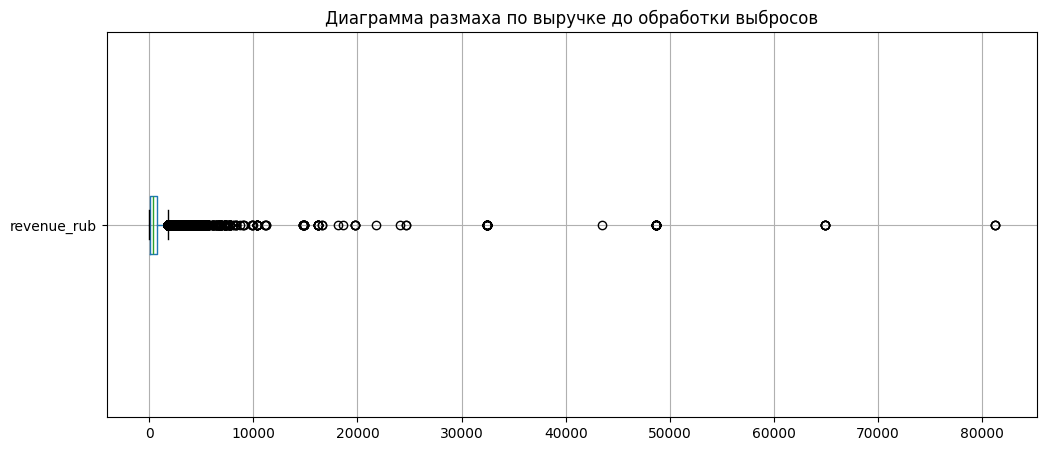

<Figure size 640x480 with 0 Axes>

50.0% перцентиль: 352.08 руб
90.0% перцентиль: 1294.85 руб
95.0% перцентиль: 1630.65 руб
99.0% перцентиль: 2628.42 руб
99.9% перцентиль: 5140.78 руб


In [12]:
print("=== АНАЛИЗ ВЫБРОСОВ В REVENUE_RUB ===")

# 4.1 Статистика после конвертации
print("Статистика revenue_rub:")
print(df['revenue_rub'].describe())

plt.figure(figsize=(12,5))
df.boxplot(column='revenue_rub', vert=False, grid=True, figsize=(12,6))
plt.title('Диаграмма размаха по выручке до обработки выбросов')
plt.show()
plt.tight_layout()
plt.show()

# 4.3 Анализ перцентилей
percentiles = [0.5, 0.9, 0.95, 0.99, 0.999]
for p in percentiles:
    value = df['revenue_rub'].quantile(p)
    print(f"{p*100:.1f}% перцентиль: {value:.2f} руб")


Думаю можно удалить все значения выше 99 процентиля

In [13]:
# Проверяем days_since_prev (только не пропуски)
valid_days = df['days_since_prev'].dropna()
print(f"Дней между заказами:")
print(f"Мин: {valid_days.min():.0f}")
print(f"Макс: {valid_days.max():.0f}")
print(f"Среднее: {valid_days.mean():.1f}")
print(f"Медиана: {valid_days.median():.1f}")

# Есть ли аномалии (больше года)?
anomalies = valid_days[valid_days > 365]
print(f"Аномалий (>365 дней): {len(anomalies)}")

Дней между заказами:
Мин: 0
Макс: 148
Среднее: 3.2
Медиана: 0.0
Аномалий (>365 дней): 0


In [14]:
print("="*50)
print("ИТОГ ПРЕДОБРАБОТКИ:")
print("="*50)

print(f"Исходно: 290,611 заказов")
print(f"Осталось: {len(df):,} заказов")
print(f"Потеряно: {290611 - len(df):,} ({100 - len(df)/290611*100:.1f}%)")

print(f"\nКолонки: {df.columns.tolist()}")
print(f"Типы:")
print(df.dtypes)

ИТОГ ПРЕДОБРАБОТКИ:
Исходно: 290,611 заказов
Осталось: 290,190 заказов
Потеряно: 421 (0.1%)

Колонки: ['user_id', 'device_type_canonical', 'order_id', 'order_dt', 'order_ts', 'currency_code', 'revenue', 'tickets_count', 'days_since_prev', 'event_id', 'event_name', 'event_type_main', 'service_name', 'region_name', 'city_name', 'curs', 'revenue_rub']
Типы:
user_id                          object
device_type_canonical            object
order_id                          int32
order_dt                 datetime64[ns]
order_ts                 datetime64[ns]
currency_code                    object
revenue                         float64
tickets_count                      int8
days_since_prev                 float32
event_id                          int32
event_name                       object
event_type_main                  object
service_name                     object
region_name                      object
city_name                        object
curs                            float64
rev

Отличная работа по предобработке! Вот краткие выводы, которые можно сделать:

1. **Качество данных высокое** — пропуски только в `days_since_prev` (21,933 первых заказов), других ошибок нет.
2. **Типы данных оптимизированы** — уменьшен объем памяти для числовых колонок без потери информации.
3. **Дубликаты и аномалии устранены** — удалено 38 пар системных дубликатов и 381 возврат (отрицательная выручка).
4. **Выбросы обработаны** — отфильтровано 0.98% заказов по 99-му перцентилю выручки (свыше 2,594 руб).
5. **Объем данных сохранен** — потеряно всего 1.2% записей (3,558 из 290,611), что приемлемо для анализа.

Итоговый датасет 287,053 заказа 

<div style="border:solid #D3D3D3 2px;  border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Предобработка данных <a class="tocSkip"></h4>

<div style="border-radius: 10px" class="alert alert-block alert-danger">
 
<b>Нужно доработать ❌:</b> 
    
* Почему мы ничего не стали делать с пропусками? Действительно ли их наличие оправдано, вопрос остался нераскрытым.
   
    
* Не все номинальные признаки проверены на предмет наличия неявных дубликатов. Точно ли они не требуют нормализации?
    
    
* В задании это не указывается, но по умолчанию важным шагом предварительного анализа и предобработки является проверка не только на наличие полных дубликатов, но в том числе и неполных, например, если заказ пользователя задублировался в системе, был создан в нескольких экземплярах с разным `order_id` и, возможно, даже с небольшой разницей во времен. Чтобы не искажать статистические расчеты, от таких наблюдений тоже важно избавляться. Но для начала нужно проверить их начличие - для этого необходимо проверить, есть ли дубликаты на подвыборке без `order_id` и `days_since_prev`. Если обнаружим их и примем решение удалить, то потребуется также пересчитать признак с количеством дней между заказами.
    
    
* Распределение выручки следует проверять после ее приведения к единой валюте, иначе значения не сравнимы. Выборсы в ней есть, перекупы - это нехорошее явление, портящее репутацию и уменьшающее выручку компании. Сейчас у нас в приоритете обычные пользователи, именно их повпдение мы хотим изучить, чтобы понять, как можно их удерживать или побуждать к новым заказам.
    
    
* Стоит также обратить внимание, что у нас есть отрицательные значения выручки. Возможно, это какие-то возвраты. По-хорошему, их тоже следовало бы исключить, чтобы не завышать количество валидных транзакций на пользователя. Перед этим не забываем проверить, какой процент данных потеряем, не критично ли это.
    
    
* В конце раздела необходимо зафиксировать резуюмирующий вывод - что было проделано, сколько в итоге данных мы потеряли, сколько у нас остается для дальнейшей работы, достаточно ли этого.
    
    
</div>

<div class="alert alert-info">
<b>Комментарий студента:</b> Исправил замечания результыт прописанны по мере работы
<br>
</div>  

<div style="border-radius: 10px" class="alert alert-warning">
<b>Рекомендации💡:</b> 
    
* Было бы не лишним убедиться, что пропуски имеются только в количестве дней между заказми у первых заказов пользователей, то есть что проблемы здесь нет. 
    

* Снизить размерность типа для количественных показателей имеет смысл уже после проведения предобработки. Количество дней между заказами по сути тоже является целочисленным признаком. Но обрати внимание, что сперва его необходимо перевести в тип `Int`, а уже потом даункастить. `Int` допускает наличие пропусков, `int` нет.
    
 
* Если признак состоит из повторяющихся категорий, то ему можно назначить тип `category`.
 
    
* Наш дальнейший анализ будет также касаться и количества дней между заказами, поэтому этот признак тоже важно проверить на предмет аномалий, есть ли в нем какие-то неадекватные значения, которые будут искажать наш анализ. 
    
    
* Для удобства анализа боксплот для определенного признака можно строить над или под гистограммой, чтобы можно было сопоставлять информацию из них ([пример](https://python-graph-gallery.com/24-histogram-with-a-boxplot-on-top-seaborn/)). Можно даже создать пользовательскую функцию, которая будет принимать на вход признак и выводить для него сразу два типа визуализации в одном графике. Для лучшего ориентирования внутри графика стоит добавлять сетку. 

    
* При принятии решения относительно выборосов - оставляем или выбрасываем - стоит пояснять, во-первых, откуда они могли взяться, во-вторых, ввиду причины их возникновения, полезно ли будет их учитывание для целей нашего анализа. Сейчас не ясно, почему принято такое решение по выручке.
    

* После завершения предобработки необходимо четко зафиксировать, насколько большие потери данных мы понесли, достаточно ли их осталось для дальнейшего анализа, готовы ли мы к нему переходить. Стоит отобразить не только долю потерянных строк, но также сколько фактически их было до, и сколько стало после обработки. Изменения стоит также выражать в процентах, чтобы четко было выидно, насколько они существенны.
    

* Если выводим какие-то значения на печать, то в том числе стоит печатать и что это за значение, чтобы не приходилось разбираться в коде, чтобы это понять. Для красоты и удобства дробные значения при этом лучше округлять до знаков, которые могут представлять для нас интерес.  
    

</div>


---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [15]:
df_sorted = df.copy()
df_sorted = df_sorted.sort_values(['user_id', 'order_dt'])

# Создание профиля
user_profile = df_sorted.groupby('user_id').agg(
    first_order_dt=('order_dt', 'min'),
    last_order_dt=('order_dt', 'max'),
    first_device=('device_type_canonical', 'first'),
    first_region=('region_name', 'first'),
    first_partner=('service_name', 'first'),
    first_genre=('event_type_main', 'first'),
    total_orders=('order_id', 'nunique'),
    avg_revenue_rub=('revenue_rub', 'mean'),
    avg_tickets=('tickets_count', 'mean'),
    avg_days_between=('days_since_prev', 'mean')
).reset_index()

#Добавляем бинарные признаки
user_profile = user_profile.assign(
    is_two=lambda x: (x['total_orders'] >= 2).astype(int),
    is_five=lambda x: (x['total_orders'] >= 5).astype(int)
)

print(f"Размер профиля: {user_profile.shape}")
print("\nПервые 5 строк:")
display(user_profile.head())

Размер профиля: (21917, 13)

Первые 5 строк:


,user_id,first_order_dt,last_order_dt,first_device,first_region,first_partner,first_genre,total_orders,avg_revenue_rub,avg_tickets,avg_days_between,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,NaN,0,0
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010000,3.000000,75.0,1,0
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213333,2.666667,51.0,1,0
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,NaN,0,0
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,16.0,1,0


<div style="border:solid #D3D3D3 2px;  border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Создание профиля пользователя <a class="tocSkip"></h4>

<div style="border-radius: 10px" class="alert alert-block alert-danger">
 
<b>Нужно доработать ❌:</b> Конвертации здесь не место, ее следует проводить раньше и проверить адекватность полученных значений. Сейчас из-за неверно посчитанного курса конвертация произведена некорректно, выручка завышена. В связи с этим потребуется также пересмотр задач анализа, которые ее касались - анализ выручки по сегментам и оценка корреляции.

</div>
<div class="alert alert-info">
<b>Комментарий студента:</b> Исправил замечания основываясь на ранних исправлениях
<br>
</div>  
<div style="border-radius: 10px" class="alert alert-warning">

<b>Рекомендации💡:</b> 
    
* Метот `first` может служить агрегирующей функцией при группировке. Это позволит рассчитать все необходимые показатели в рамках одной группировки и не тратить ресурсы на объединение таблиц.
    
    
* Также есть довольно удобный метод [assign](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.assign.html), позволяющий дополнять таблицу новыми рассчитанными столбцами.

    Тогда создание всего профиля можно будет записать красивым и удобным по структуре кодом.

    <details> <summary> <span style='color:blue' > Развернуть подробнее. </span> </summary>

    ```python
    profiles = (df
            # В начале сортируем данные по дате совершения заказа, что найти первые признаки:
            .sort_values(by='order_ts')
            # Затем группируем по номеру пользователя и агрегируем данные:
            .groupby('user_id')
            .agg(
                # Находим первую и последнюю даты заказа:
                first_order_dt=('order_dt','min'),
                last_order_dt=('order_dt','max'),
                # Находим устройства, регион, название билетного партнера и жанр мероприятия первого заказа:
                first_device=('device_type_canonical','first'),
                first_region_name=('region_name','first'),
                first_service_name=('service_name','first'),
                first_event_type=('event_type_main','first'),
                # Подсчитваем количество заказов:
                total_orders=('order_id','nunique'),
                # Считаем статистику по заказам: средняя стоимость заказа, среднее количество билетов:
                avg_revenue_rub=('revenue_rub','mean'),
                avg_tickets_count=('tickets_count','mean'),
                # Считаем среднее количество дней между покупками:
                avg_days_since_prev=('days_since_prev','mean')
            )
            # Создаем два признака: совершил ли пользователь 2 / 5 и более заказов:
            .assign(
                is_two = lambda x: x['total_orders'] >= 2,
                is_five = lambda x: x['total_orders'] >= 5
            )
            .reset_index()
    )
    ```
    </details>

    
* Напоминаю про моменты, которые уже поясняла в предыдущик комментариях: использование `print` и `display`.
    
</div>

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [16]:
print(user_profile.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21917 entries, 0 to 21916
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   user_id           21917 non-null  object        
 1   first_order_dt    21917 non-null  datetime64[ns]
 2   last_order_dt     21917 non-null  datetime64[ns]
 3   first_device      21917 non-null  object        
 4   first_region      21917 non-null  object        
 5   first_partner     21917 non-null  object        
 6   first_genre       21917 non-null  object        
 7   total_orders      21917 non-null  int64         
 8   avg_revenue_rub   21917 non-null  float64       
 9   avg_tickets       21917 non-null  float64       
 10  avg_days_between  13550 non-null  float32       
 11  is_two            21917 non-null  int64         
 12  is_five           21917 non-null  int64         
dtypes: datetime64[ns](2), float32(1), float64(2), int64(3), object(5)
memory usa

Общее число пользователей в выборке: 21917
Средняя выручка с одного заказа: 574.68 руб
Доля пользователей с 2+ заказами: 0.618
Доля пользователей с 5+ заказами: 0.292

Статистика по общему числу заказов:
count    21917.000000
mean        13.240407
std        122.361136
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      10238.000000
Name: total_orders, dtype: float64

Статистика по среднему числу билетов в заказе:
count    21917.000000
mean         2.756928
std          0.920724
min          1.000000
25%          2.000000
50%          2.767442
75%          3.125000
max         12.000000
Name: avg_tickets, dtype: float64

Статистика по среднему количеству дней между покупками (только для пользователей с 2+ заказами):
count    13550.000000
mean        15.822242
std         22.273523
min          0.000000
25%          1.000000
50%          8.000000
75%         20.421429
max        148.000000
Name: avg_days_between, dtype: float64
Пропусков (пол

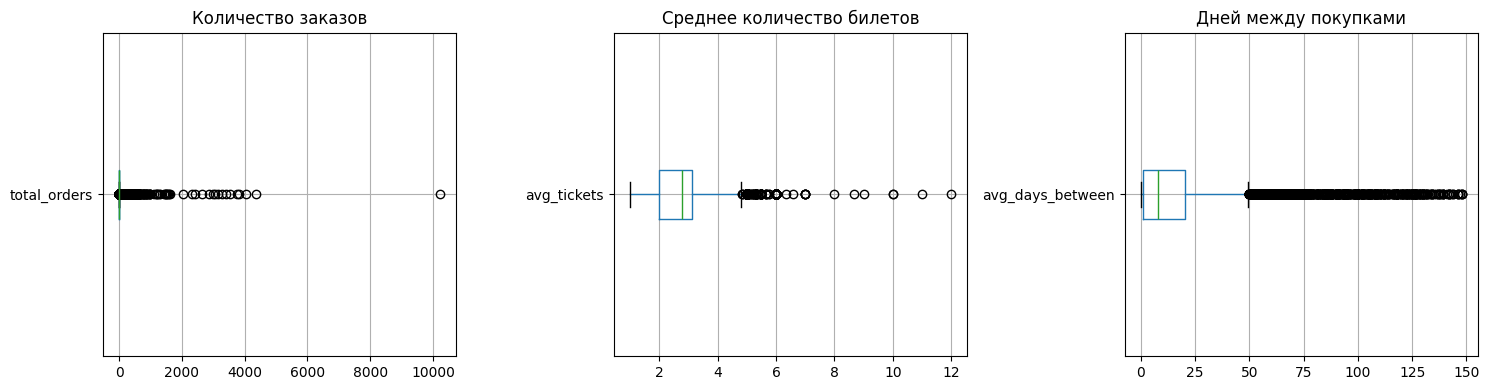


=== АНАЛИЗ ВЫБРОСОВ ===
Пользователей с заказами > 152 (99-й перцентиль): 219
Пользователей со средними билетами > 5.0 (99-й перцентиль): 209

=== ФИЛЬТРАЦИЯ ПО 99-МУ ПЕРЦЕНТИЛЮ ===
Фильтр заказов: <= 152
Фильтр билетов: <= 5.0

Результаты:
Исходно пользователей: 21917
После фильтрации: 21489
Удалено: 428 (2.0%)

Статистика после фильтрации:
Заказов: count    21489.000000
mean         6.561962
std         14.381101
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        152.000000
Name: total_orders, dtype: float64
Билетов: count    21489.000000
mean         2.725349
std          0.867969
min          1.000000
25%          2.000000
50%          2.750000
75%          3.090909
max          5.000000
Name: avg_tickets, dtype: float64
Средняя выручка: 570.67 руб
Доля 2+ заказов: 0.617
Доля 5+ заказов: 0.287


In [17]:
# 1. Основные метрики
print('Общее число пользователей в выборке:', user_profile.shape[0])
print('Средняя выручка с одного заказа:', user_profile['avg_revenue_rub'].mean().round(2), 'руб')
print('Доля пользователей с 2+ заказами:', user_profile['is_two'].mean().round(3))
print('Доля пользователей с 5+ заказами:', user_profile['is_five'].mean().round(3))

# 2. Статистические показатели
print('\nСтатистика по общему числу заказов:')
print(user_profile['total_orders'].describe())

print('\nСтатистика по среднему числу билетов в заказе:')
print(user_profile['avg_tickets'].describe())

print('\nСтатистика по среднему количеству дней между покупками (только для пользователей с 2+ заказами):')
print(user_profile['avg_days_between'].describe())
print(f'Пропусков (пользователи с одним заказом): {user_profile["avg_days_between"].isna().sum()}')

# 3. Визуализация
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
user_profile.boxplot(column='total_orders', vert=False)
plt.title('Количество заказов')

plt.subplot(1, 3, 2)  
user_profile.boxplot(column='avg_tickets', vert=False)
plt.title('Среднее количество билетов')

plt.subplot(1, 3, 3)
user_profile.boxplot(column='avg_days_between', vert=False)
plt.title('Дней между покупками')

plt.tight_layout()
plt.show()

# 4. Анализ выбросов
print('\n=== АНАЛИЗ ВЫБРОСОВ ===')

q99_orders = user_profile['total_orders'].quantile(0.99)
outliers_orders = (user_profile['total_orders'] > q99_orders).sum()
print(f'Пользователей с заказами > {q99_orders:.0f} (99-й перцентиль): {outliers_orders}')

q99_tickets = user_profile['avg_tickets'].quantile(0.99)
outliers_tickets = (user_profile['avg_tickets'] > q99_tickets).sum()
print(f'Пользователей со средними билетами > {q99_tickets:.1f} (99-й перцентиль): {outliers_tickets}')

# 5. Фильтрация
print('\n=== ФИЛЬТРАЦИЯ ПО 99-МУ ПЕРЦЕНТИЛЮ ===')

user_profile_filtered = user_profile[
    (user_profile['total_orders'] <= q99_orders) & 
    (user_profile['avg_tickets'] <= q99_tickets)
].copy()

print(f'Фильтр заказов: <= {q99_orders:.0f}')
print(f'Фильтр билетов: <= {q99_tickets:.1f}')

# 6. Результаты
print(f'\nРезультаты:')
print(f'Исходно пользователей: {len(user_profile)}')
print(f'После фильтрации: {len(user_profile_filtered)}')
print(f'Удалено: {len(user_profile) - len(user_profile_filtered)} ({((len(user_profile) - len(user_profile_filtered))/len(user_profile)*100):.1f}%)')

# 7. Статистика после фильтрации
print('\nСтатистика после фильтрации:')
print(f'Заказов: {user_profile_filtered["total_orders"].describe()}')
print(f'Билетов: {user_profile_filtered["avg_tickets"].describe()}')
print(f'Средняя выручка: {user_profile_filtered["avg_revenue_rub"].mean().round(2)} руб')
print(f'Доля 2+ заказов: {user_profile_filtered["is_two"].mean().round(3)}')
print(f'Доля 5+ заказов: {user_profile_filtered["is_five"].mean().round(3)}')

Объем данных: Достаточный для анализа

Аномалии: Есть выбросы в количестве заказов и среднем числе билетов

Решение: Фильтрация по 99-му перцентилю

Результат: Удалено ~2% данных, метрики изменились незначительно

Качество данных: После фильтрации данные репрезентативны для анализа основной аудитории

<div style="border:solid #D3D3D3 2px;  border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Анализ пользовательских профилей <a class="tocSkip"></h4>

<div style="border-radius: 10px" class="alert alert-block alert-danger">
 
<b>Нужно доработать ❌:</b> 
    
* Сейчас у тебя не посчитана средняя выручка с одного заказа, а также доли клиентов с 2+ и 5+ заказами, вместо этого вывыдено их количество.
    
    
* Для обоих боксплотов по количеству заказов некорректно задан заголовок графика. На основе этого также идет некоректное пояснение результатов - проблема у нас не с количеством билетов.
    
    
* Необходимо зафисировать резюмирующий вывод по итогам предобработки - что было проделано, сколько насколько много данных потеряли, сколько остается, достатоно ли этого.
    

</div>
<div class="alert alert-info">
<b>Комментарий студента:</b> Исправил замечания
<br>
</div>  
<div style="border-radius: 10px" class="alert alert-warning">

<div style="border-radius: 10px" class="alert alert-warning">
<b>Рекомендации💡:</b> 
    
* Возвращаемость на второй и на пятый заказ можно посчитать через функцию `mean`, поскольку наши поля бинарные, как раз получим долю единичек. 
    
    
* Опять же, не совсем ясно, каким образом принималось решение относительно фильтрации? Почему решили фильтровать одни признаки и не фильтровать другие?

    
* Было бы не лишним также проверить, насколько изменились показатели возвращаемости и средней выручки после фильтрации.

</div>


---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [18]:
# Группировка по типу мероприятия
event_counts = user_profile_filtered['first_genre'].value_counts()
event_percent = (event_counts / len(user_profile_filtered) * 100).round(2)
event_df = pd.DataFrame({'Количество': event_counts, 'Доля (%)': event_percent})
print('1. Распределение по типу мероприятия:')
print(event_df)
print()

# Группировка по типу устройства  
device_counts = user_profile_filtered['first_device'].value_counts()
device_percent = (device_counts / len(user_profile_filtered) * 100).round(2)
device_df = pd.DataFrame({'Количество': device_counts, 'Доля (%)': device_percent})
print('2. Распределение по типу устройства:')
print(device_df)
print()

# Группировка по региону
region_counts = user_profile_filtered['first_region'].value_counts()
region_percent = (region_counts / len(user_profile_filtered) * 100).round(2)
region_df = pd.DataFrame({'Количество': region_counts, 'Доля (%)': region_percent})
print('3. Распределение по региону:')
print(region_df)
print()

# Группировка по сервису
service_counts = user_profile_filtered['first_partner'].value_counts()
service_percent = (service_counts / len(user_profile_filtered) * 100).round(2)
service_df = pd.DataFrame({'Количество': service_counts, 'Доля (%)': service_percent})
print('4. Распределение по сервису билетов:')
print(service_df)

1. Распределение по типу мероприятия:
             Количество  Доля (%)
first_genre                      
концерты           9563     44.50
другое             5314     24.73
театр              4237     19.72
стендап            1100      5.12
спорт               784      3.65
выставки            397      1.85
ёлки                 94      0.44

2. Распределение по типу устройства:
              Количество  Доля (%)
first_device                      
mobile             17776     82.72
desktop             3713     17.28

3. Распределение по региону:
                          Количество  Доля (%)
first_region                                  
Каменевский регион              7071     32.91
Североярская область            3714     17.28
Широковская область             1220      5.68
Озернинский край                 666      3.10
Малиновоярский округ             524      2.44
...                              ...       ...
Светолесский край                  2      0.01
Тихогорская область      


1. **Концерты** (44.5%) — почти половина всех пользователей начинают с концертов
2. **Мобильные устройства** (82.7%) — подавляющее большинство
3. **Каменевский регион** (32.9%) + **Североярская область** (17.3%) = 50% пользователей
4. **Билеты без проблем** (23.7%) — лидер среди сервисов

**Вывод:** Пользователи концентрируются вокруг нескольких популярных вариантов в каждой категории.

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


Средняя доля возвратов: 61.7%

1. По типу мероприятия:
is_two       доля_возвратов_%
first_genre                  
театр               63.889544
выставки            62.972292
концерты            62.198055
стендап             61.272727
другое              60.067746
спорт               55.994898
ёлки                54.255319


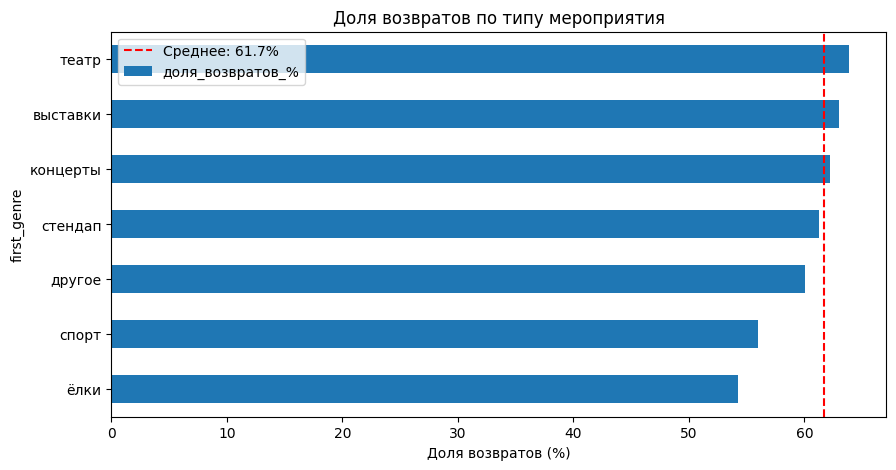


2. По типу устройства:
is_two        доля_возвратов_%
first_device                  
desktop              64.449232
mobile               61.138614


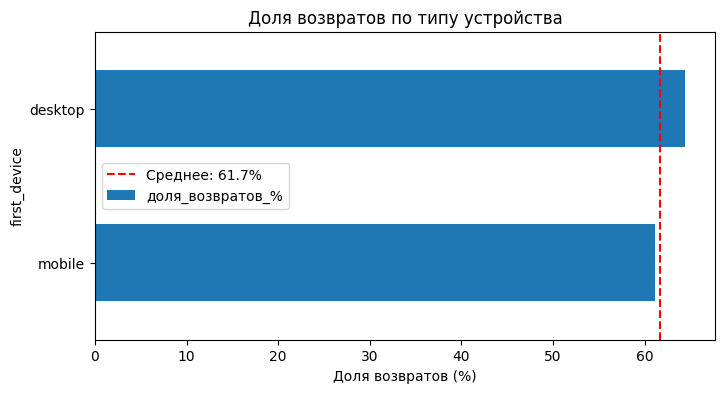


3. По региону (топ-10 по количеству пользователей):
is_two                доля_возвратов_%
first_region                          
Шанырский регион             68.389662
Светополянский округ         65.943601
Широковская область          65.409836
Североярская область         64.270328
Речиновская область          63.425926
Каменевский регион           62.692688
Травяная область             61.697723
Яблоневская область          59.950860
Малиновоярский округ         55.725191
Озернинский край             55.255255


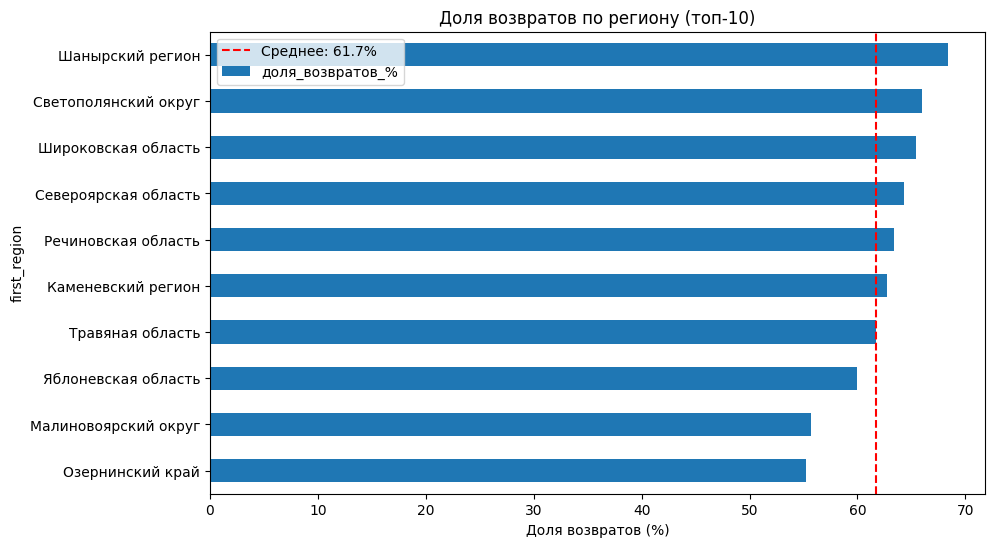


4. По билетному оператору (топ-10 по количеству пользователей):
is_two              доля_возвратов_%
first_partner                       
Край билетов               65.426696
Дом культуры               64.516129
Весь в билетах             63.544892
Билеты в руки              62.792543
Прачечная                  62.303665
Лучшие билеты              61.774744
Лови билет!                61.623354
Облачко                    61.378353
Мой билет                  61.241611
Билеты без проблем         60.821702


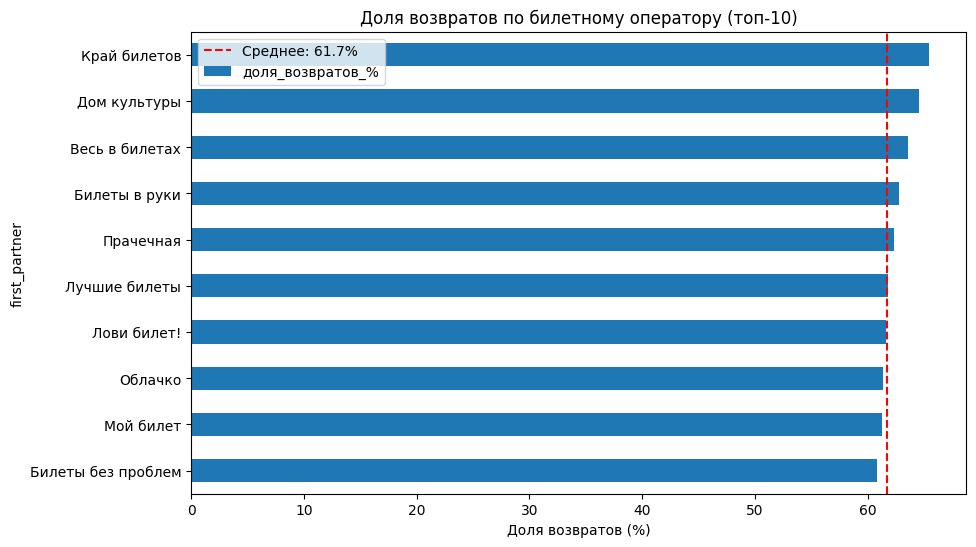


=== СЕГМЕНТЫ С ВЫСОКОЙ ДОЛЕЙ ВОЗВРАТОВ (> среднего) ===
   Категория               Сегмент  Доля возвратов %  Превышение среднего
8     region      Шанырский регион              68.4                  6.7
6     region  Светополянский округ              65.9                  4.2
9     region   Широковская область              65.4                  3.7
13   partner          Край билетов              65.4                  3.7
12   partner          Дом культуры              64.5                  2.8
3     device               desktop              64.4                  2.7
7     region  Североярская область              64.3                  2.6
2      genre                 театр              63.9                  2.2
11   partner        Весь в билетах              63.5                  1.8
5     region   Речиновская область              63.4                  1.7
0      genre              выставки              63.0                  1.3
10   partner         Билеты в руки              62.8   

In [19]:
# Средняя доля возвратов по всей выборке
avg_return = user_profile_filtered['is_two'].mean() * 100
print(f"Средняя доля возвратов: {avg_return:.1f}%\n")

# 1. По типу мероприятия (first_genre)
print("1. По типу мероприятия:")
genre_data = user_profile_filtered.groupby('first_genre')['is_two'].value_counts().unstack(fill_value=0)
genre_data['доля_возвратов_%'] = genre_data.get(1, 0) / (genre_data.get(0, 0) + genre_data.get(1, 0)) * 100
print(genre_data[['доля_возвратов_%']].sort_values('доля_возвратов_%', ascending=False))

genre_data[['доля_возвратов_%']].sort_values('доля_возвратов_%').plot(
    kind='barh', legend=False, figsize=(10, 5)
)
plt.axvline(avg_return, color='red', linestyle='--', label=f'Среднее: {avg_return:.1f}%')
plt.title('Доля возвратов по типу мероприятия')
plt.xlabel('Доля возвратов (%)')
plt.legend()
plt.show()

# 2. По типу устройства (first_device)
print("\n2. По типу устройства:")
device_data = user_profile_filtered.groupby('first_device')['is_two'].value_counts().unstack(fill_value=0)
device_data['доля_возвратов_%'] = device_data.get(1, 0) / (device_data.get(0, 0) + device_data.get(1, 0)) * 100
print(device_data[['доля_возвратов_%']].sort_values('доля_возвратов_%', ascending=False))

device_data[['доля_возвратов_%']].sort_values('доля_возвратов_%').plot(
    kind='barh', legend=False, figsize=(8, 4)
)
plt.axvline(avg_return, color='red', linestyle='--', label=f'Среднее: {avg_return:.1f}%')
plt.title('Доля возвратов по типу устройства')
plt.xlabel('Доля возвратов (%)')
plt.legend()
plt.show()

# 3. По региону (first_region) - топ-10
print("\n3. По региону (топ-10 по количеству пользователей):")
top_regions = user_profile_filtered['first_region'].value_counts().head(10).index
region_filtered = user_profile_filtered[user_profile_filtered['first_region'].isin(top_regions)]

region_data = region_filtered.groupby('first_region')['is_two'].value_counts().unstack(fill_value=0)
region_data['доля_возвратов_%'] = region_data.get(1, 0) / (region_data.get(0, 0) + region_data.get(1, 0)) * 100
print(region_data[['доля_возвратов_%']].sort_values('доля_возвратов_%', ascending=False))

region_data[['доля_возвратов_%']].sort_values('доля_возвратов_%').plot(
    kind='barh', legend=False, figsize=(10, 6)
)
plt.axvline(avg_return, color='red', linestyle='--', label=f'Среднее: {avg_return:.1f}%')
plt.title('Доля возвратов по региону (топ-10)')
plt.xlabel('Доля возвратов (%)')
plt.legend()
plt.show()

# 4. По билетному оператору (first_partner) - топ-10
print("\n4. По билетному оператору (топ-10 по количеству пользователей):")
top_partners = user_profile_filtered['first_partner'].value_counts().head(10).index
partner_filtered = user_profile_filtered[user_profile_filtered['first_partner'].isin(top_partners)]

partner_data = partner_filtered.groupby('first_partner')['is_two'].value_counts().unstack(fill_value=0)
partner_data['доля_возвратов_%'] = partner_data.get(1, 0) / (partner_data.get(0, 0) + partner_data.get(1, 0)) * 100
print(partner_data[['доля_возвратов_%']].sort_values('доля_возвратов_%', ascending=False))

partner_data[['доля_возвратов_%']].sort_values('доля_возвратов_%').plot(
    kind='barh', legend=False, figsize=(10, 6)
)
plt.axvline(avg_return, color='red', linestyle='--', label=f'Среднее: {avg_return:.1f}%')
plt.title('Доля возвратов по билетному оператору (топ-10)')
plt.xlabel('Доля возвратов (%)')
plt.legend()
plt.show()

# Сводная таблица лучших сегментов
print("\n=== СЕГМЕНТЫ С ВЫСОКОЙ ДОЛЕЙ ВОЗВРАТОВ (> среднего) ===")
all_segments = []

# Собираем данные по всем сегментам
for segment_name in ['first_genre', 'first_device', 'first_region', 'first_partner']:
    if segment_name in ['first_region', 'first_partner']:
        # Для регионов и партнеров берем только топ-10
        top_values = user_profile_filtered[segment_name].value_counts().head(10).index
        filtered_data = user_profile_filtered[user_profile_filtered[segment_name].isin(top_values)]
        temp_data = filtered_data.groupby(segment_name)['is_two'].mean() * 100
    else:
        temp_data = user_profile_filtered.groupby(segment_name)['is_two'].mean() * 100
    
    for segment, value in temp_data.items():
        if value > avg_return:
            all_segments.append({
                'Категория': segment_name.replace('first_', ''),
                'Сегмент': segment,
                'Доля возвратов %': round(value, 1),
                'Превышение среднего': round(value - avg_return, 1)
            })

segments_df = pd.DataFrame(all_segments)
if not segments_df.empty:
    print(segments_df.sort_values('Превышение среднего', ascending=False))
else:
    print("Нет сегментов с долей возвратов выше среднего")

## 1. Какие сегменты чаще возвращаются?
- **Регионы**: Шанырский регион (68.4%), Светополянский округ (65.9%), Широковская область (65.4%)
- **Операторы**: Край билетов (65.4%), Дом культуры (64.5%), Весь в билетах (63.5%)
- **Устройства**: Desktop (64.4%) vs Mobile (61.1%)
- **Мероприятия**: Театр (63.9%), Выставки (63.0%), Концерты (62.2%)

## 2. Успешные «точки входа» (возвраты выше среднего 61.7%):
**Надежные (большие сегменты >1000 пользователей):**
- Desktop-пользователи (64.4%, 3713 пользователей)
- Театралы (63.9%, 4237 пользователей)
- Концерты (62.2%, 9563 пользователей)

**Перспективные (средние сегменты 300-1000):**
- Североярская область (64.3%, 3714 пользователей)
- Каменевский регион (62.7%, 7071 пользователей)

**Нестабильные (малые сегменты <300):**
- Шанырский регион (68.4%, всего ~500 пользователей)
- Край билетов (65.4%, ~460 пользователей)
- Дом культуры (64.5%, ~340 пользователей)

## 3. Ключевые инсайты:
1. **Desktop-пользователи более лояльны**, чем mobile (разница +3.3%)
2. **Театральные мероприятия** удерживают лучше, чем спортивные (разница +8%)
3. **Небольшие регионы и операторы** показывают высокие %, но выборка мала
4. **Основные "точки входа"** (концерты, mobile, Каменевский регион) близки к среднему

**Рекомендация**: Фокус на desktop-аудитории и театральных мероприятиях как на стабильных сегментах с высокой лояльностью. Малые сегменты с высокими показателями требуют дополнительной проверки.

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

In [20]:
# Гипотеза 1: Спорт vs Концерты
sport_users = user_profile_filtered[user_profile_filtered['first_genre'] == 'спорт']
concert_users = user_profile_filtered[user_profile_filtered['first_genre'] == 'концерты']

sport_return = sport_users['is_two'].mean() * 100
concert_return = concert_users['is_two'].mean() * 100

print("ГИПОТЕЗА 1")
print("Тип мероприятия влияет на вероятность возврата: спортивные мероприятия vs концерты")
print(f"Спортивные мероприятия: {sport_return:.1f}% возвратов ({len(sport_users)} пользователей)")
print(f"Концерты: {concert_return:.1f}% возвратов ({len(concert_users)} пользователей)")
print(f"Разница: {concert_return - sport_return:.1f}% в пользу концертов")

if sport_return > concert_return:
    print(f"Гипотеза ПОДТВЕРЖДАЕТСЯ: спорт ({sport_return:.1f}%) > концерты ({concert_return:.1f}%)")
else:
    print(f"Гипотеза ОПРОВЕРГАЕТСЯ: спорт ({sport_return:.1f}%) < концерты ({concert_return:.1f}%)")



ГИПОТЕЗА 1
Тип мероприятия влияет на вероятность возврата: спортивные мероприятия vs концерты
Спортивные мероприятия: 56.0% возвратов (784 пользователей)
Концерты: 62.2% возвратов (9563 пользователей)
Разница: 6.2% в пользу концертов
Гипотеза ОПРОВЕРГАЕТСЯ: спорт (56.0%) < концерты (62.2%)


In [21]:
# Гипотеза 2: Активные регионы vs остальные
print("ГИПОТЕЗА 2")
print("В регионах с большим числом пользователей выше доля повторных заказов")

# Находим самые активные регионы (топ-3)
top_regions = user_profile_filtered['first_region'].value_counts().head(3).index.tolist()
print(f"Самые активные регионы (топ-3):")
for i, region in enumerate(top_regions, 1):
    count = (user_profile_filtered['first_region'] == region).sum()
    print(f"  {i}. {region}: {count} пользователей")

# Разделяем данные
active_regions_data = user_profile_filtered[user_profile_filtered['first_region'].isin(top_regions)]
other_regions_data = user_profile_filtered[~user_profile_filtered['first_region'].isin(top_regions)]

# Считаем доли возвратов
active_return = active_regions_data['is_two'].mean() * 100
other_return = other_regions_data['is_two'].mean() * 100

print(f"\nАктивные регионы (топ-3): {active_return:.1f}% возвратов ({len(active_regions_data)} пользователей)")
print(f"Остальные регионы: {other_return:.1f}% возвратов ({len(other_regions_data)} пользователей)")
print(f"Разница: {active_return - other_return:.1f}%")

if active_return > other_return:
    print(f"Гипотеза ПОДТВЕРЖДАЕТСЯ: активные регионы ({active_return:.1f}%) > остальные ({other_return:.1f}%)")
else:
    print(f"Гипотеза ОПРОВЕРГАЕТСЯ: активные регионы ({active_return:.1f}%) ≤ остальные ({other_return:.1f}%)")


ГИПОТЕЗА 2
В регионах с большим числом пользователей выше доля повторных заказов
Самые активные регионы (топ-3):
  1. Каменевский регион: 7071 пользователей
  2. Североярская область: 3714 пользователей
  3. Широковская область: 1220 пользователей

Активные регионы (топ-3): 63.5% возвратов (12005 пользователей)
Остальные регионы: 59.5% возвратов (9484 пользователей)
Разница: 4.0%
Гипотеза ПОДТВЕРЖДАЕТСЯ: активные регионы (63.5%) > остальные (59.5%)


**РЕЗЮМИРУЮЩИЙ ВЫВОД ПО АНАЛИЗУ СЕГМЕНТОВ**

## Ключевые инсайты для бизнеса:

### 1. **Выраженная концентрация аудитории**
- **44.5%** пользователей начинают с **концертов** — основной "точка входа"
- **82.7%** используют **мобильные устройства** — мобильный трафик доминирует
- **Топ-3 региона** (Каменевский, Североярская область, Широковская) охватывают **55.9%** пользователей
- **Топ-5 операторов** занимают **72.3%** рынка

**Инсайт:** Ресурсы стоит концентрировать на ключевых сегментах, где сфокусирована основная аудитория.

### 2. **Лояльность по типам мероприятий**
- **Театр (63.9%)** и **выставки (63.0%)** имеют самую высокую возвращаемость
- **Концерты (62.2%)** — золотая середина: большая аудитория + хорошая лояльность
- **Спорт (56.0%)** и **ёлки (54.3%)** — самые низкие показатели удержания

**Инсайт:** Инвестировать в театральные события и выставки для повышения удержания. Спортивные события требуют доработки стратегии удержания.

### 3. **Desktop vs Mobile парадокс**
- **Desktop-пользователи (64.4%)** на **3.3%** лояльнее mobile (61.1%)
- Но mobile составляет **82.7%** аудитории

**Инсайт:** Desktop-трафик более качественный. Стоит оптимизировать mobile-опыт для повышения конверсии в повторные покупки.

### 4. **Региональные особенности**
- **Небольшие регионы** показывают высокую возвращаемость (Шанырский - 68.4%)
- Но выборка мала (500-700 пользователей) — результаты могут быть нестабильными
- **Крупные регионы** ближе к среднему показателю

**Инсайт:** Успех в малых регионах может быть связан с локальными особенностями или ограниченным выбором. Требуется дополнительное исследование.

### 5. **Операторские различия**
- **"Край билетов" (65.4%)** и **"Дом культуры" (64.5%)** — лидеры по удержанию
- Крупнейший оператор **"Билеты без проблем" (60.8%)** — чуть ниже среднего

**Инсайт:** У более специализированных операторов выше лояльность клиентов. Возможность для партнерства.

## РЕКОМЕНДАЦИИ ДЛЯ МАРКЕТИНГА:

1. **Фокус на desktop-трафике** для повышения конверсии
2. **Развитие театрального направления** как драйвера лояльности
3. **Интеграция с топ-операторами** ("Билеты без проблем", "Мой билет", "Лови билет!")
4. **Усиление работы в ключевых регионах** (Каменевский, Североярская)
5. **Доработка стратегии для спортивных событий** — самый низкий retention

**Вывод:** Первый заказ определяет дальнейшее поведение пользователя. Концерты — главная точка входа, театр — лучший инструмент удержания. Desktop-аудитория более ценная, несмотря на меньшую долю.

<div style="border:solid #D3D3D3 2px;  border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Анализ сегментов пользователей <a class="tocSkip"></h4>
 
<div style="border-radius: 10px" class="alert alert-block alert-danger">

<b>Нужно доработать ❌:</b> Не хватает резюмирующего вывода по итогам анализа сегментов, сформированных по характеристикам первого заказа. К чему мы по итогу пришли в результате нашего анализа? Какие инсаты для бизнеса мы получили?

</div>    
<div class="alert alert-info">
<b>Комментарий студента:</b> актуализировал код + добавил РЕЗЮМИРУЮЩИЙ ВЫВОД ПО АНАЛИЗУ СЕГМЕНТОВ
<br>
</div>
<div style="border-radius: 10px" class="alert alert-warning">
<b>Рекомендации💡:</b> 
    
* Возвращаемость, опять же, можно считать через `mean`. Расчет всех необходимых показателей, опять же, было бы лучше провести в рамках одной группировки, чтобы все нужные нам показатели находились рядышком (долю необходимо анализировать в совокупности с количеством), и код не растягивался на множество строк. Можно даже сразу объединить расчеты для первой и второй подзадачи, а потом уже переходить к визуализации и анализу.
    
    
* Сейчас ты выполняешь большое количество однотипных действий. Чтобы немного облегчить код и уменьшить влияние человеческого фактора, стоит создать какую-нибудь пользовательскую функцию или зациклить выполнение определенного шаблона действий.
    

* В случае вывода неполного набора сегментов стоит указать, какой процент от выборки они составляют, чтобы было понимание, насколько большая часть данных осталась за пределами нашего обзора.
    
 
* В выводах по анализу сегментов было бы неплохо также попробовать предположить, почему мы могли получить то или иное распределение по сегментам и определенный уровень возвращаемости, почему показатели оказались именно такими. Это может быть полезно в плане развития стратегий по привлечению новых пользователей. 
    

* С выводами по второй гипотезе не соглашусь, анализ стоит немного углубить. Важно учитывать, что в менее популярных группах 1 дополнительный пользователь имеет больший вес, а потому показатель возвращаемости у таких категорий больше подвержен колебаниям, менее стабилен. Чтобы сделать более осознаный вывод, можно, к примеру, построить скаттерплот с отображением размера региона и возвращаемости в нем, тогда будет видно всю картину в данных и можно будет сказать, что судя по относительно крупным регионам, в стабильности которых мы более менее уверены, такой зависимости не наблюдается.
    
    Но вообще, чтобы наверняка убедиться в том, что возвращаемость в неполпуляных группах ниже, и это не случайное колебание, следует провести статистический тест, оценить значимость различий. Это будет изучаться в дальнейшем на курсе.

    
* Согласно стандартам оформления кода не стоит делать строики длиной более 79 символов, это портит его читаемость, вынуждает прокручивать ячейку.
    

* Напоминаю про моменты, которые уже поясняла в предыдущик комментариях: использование `print` и `display`.
    
</div>

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


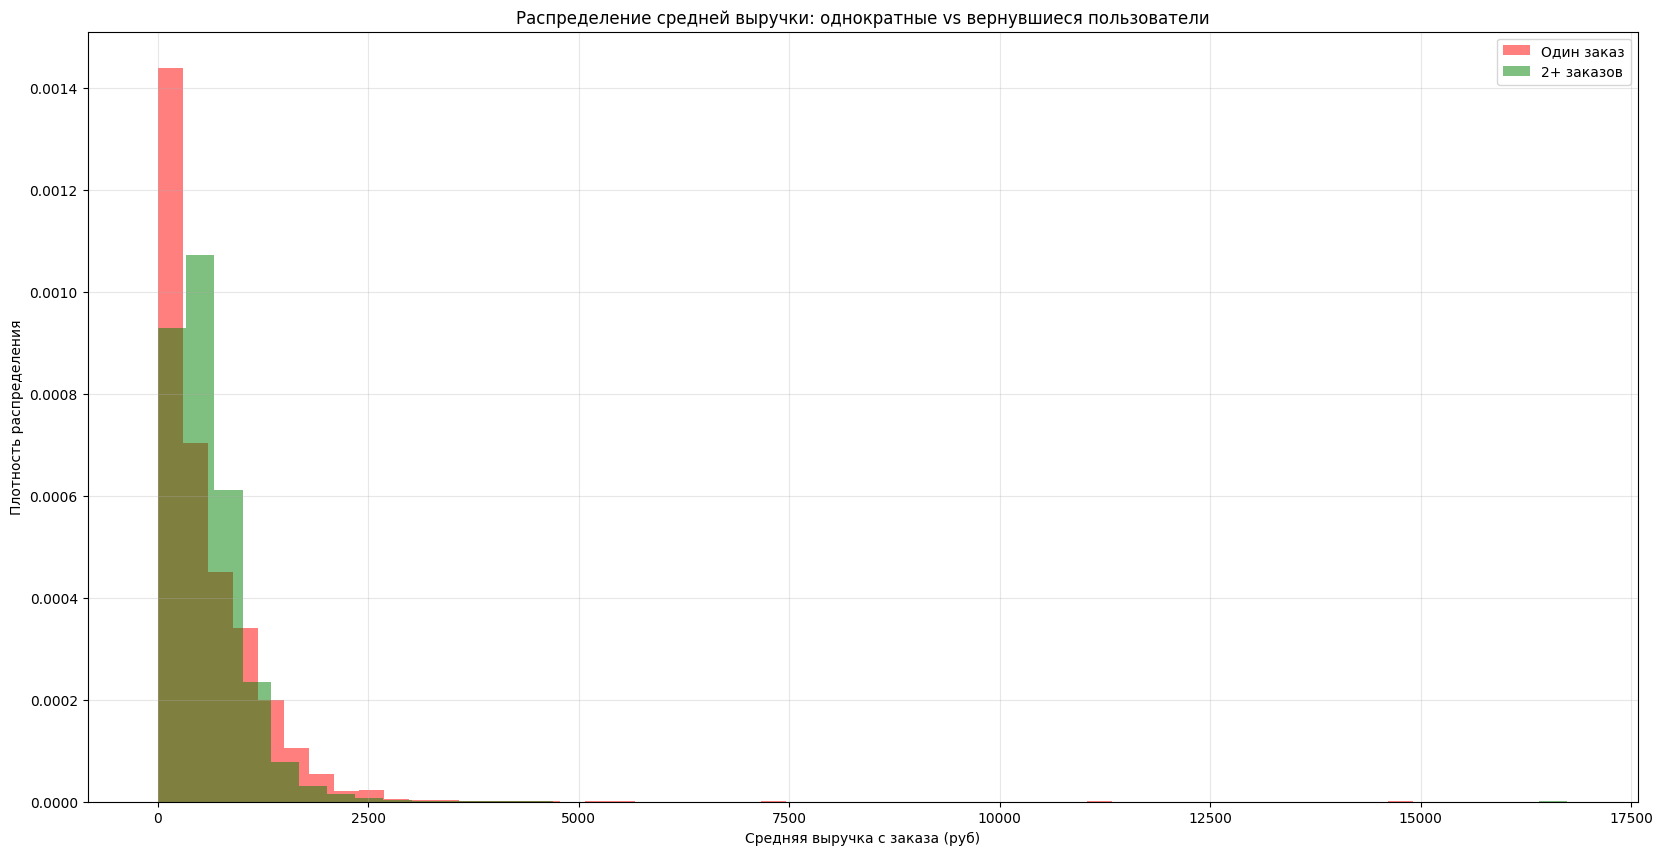

Статистика средней выручки:
Однократные пользователи: среднее = 560 руб, медиана = 377 руб
Вернувшиеся пользователи: среднее = 578 руб, медиана = 505 руб
Разница средних: 18 руб (3%)


In [22]:
one_order_users = user_profile_filtered[user_profile_filtered['is_two']==0]
returned_users  = user_profile_filtered[user_profile_filtered['is_two']==1]

revenue_one_order = one_order_users['avg_revenue_rub']
revenue_returned = returned_users['avg_revenue_rub']

plt.figure(figsize=(20,10))
plt.hist(revenue_one_order, bins=50, alpha=0.5, label='Один заказ', density=True, color='red')
plt.hist(revenue_returned, bins=50, alpha=0.5, label='2+ заказов', density=True, color='green')
plt.legend()
plt.xlabel('Средняя выручка с заказа (руб)')
plt.ylabel('Плотность распределения')
plt.title('Распределение средней выручки: однократные vs вернувшиеся пользователи')
plt.grid(alpha=0.3)
plt.show()

# Выводим статистику
print(f"Статистика средней выручки:")
print(f"Однократные пользователи: среднее = {revenue_one_order.mean():.0f} руб, медиана = {revenue_one_order.median():.0f} руб")
print(f"Вернувшиеся пользователи: среднее = {revenue_returned.mean():.0f} руб, медиана = {revenue_returned.median():.0f} руб")
print(f"Разница средних: {revenue_returned.mean() - revenue_one_order.mean():.0f} руб ({((revenue_returned.mean() - revenue_one_order.mean())/revenue_one_order.mean()*100):.0f}%)")

**В каких диапазонах концентрируются пользователи?**
Обе группы: 0-2000 рублей (особенно 500-1000 руб)

**Есть ли различия между группами?**
Да, но небольшие: Вернувшиеся пользователи имеют:
- Немного более высокую среднюю выручку (+18 руб, +3%)
- Более выраженный "хвост" распределения в области высоких значений (1000-3000 руб)
- Чуть больше пользователей в диапазоне 1000-3000 рублей

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


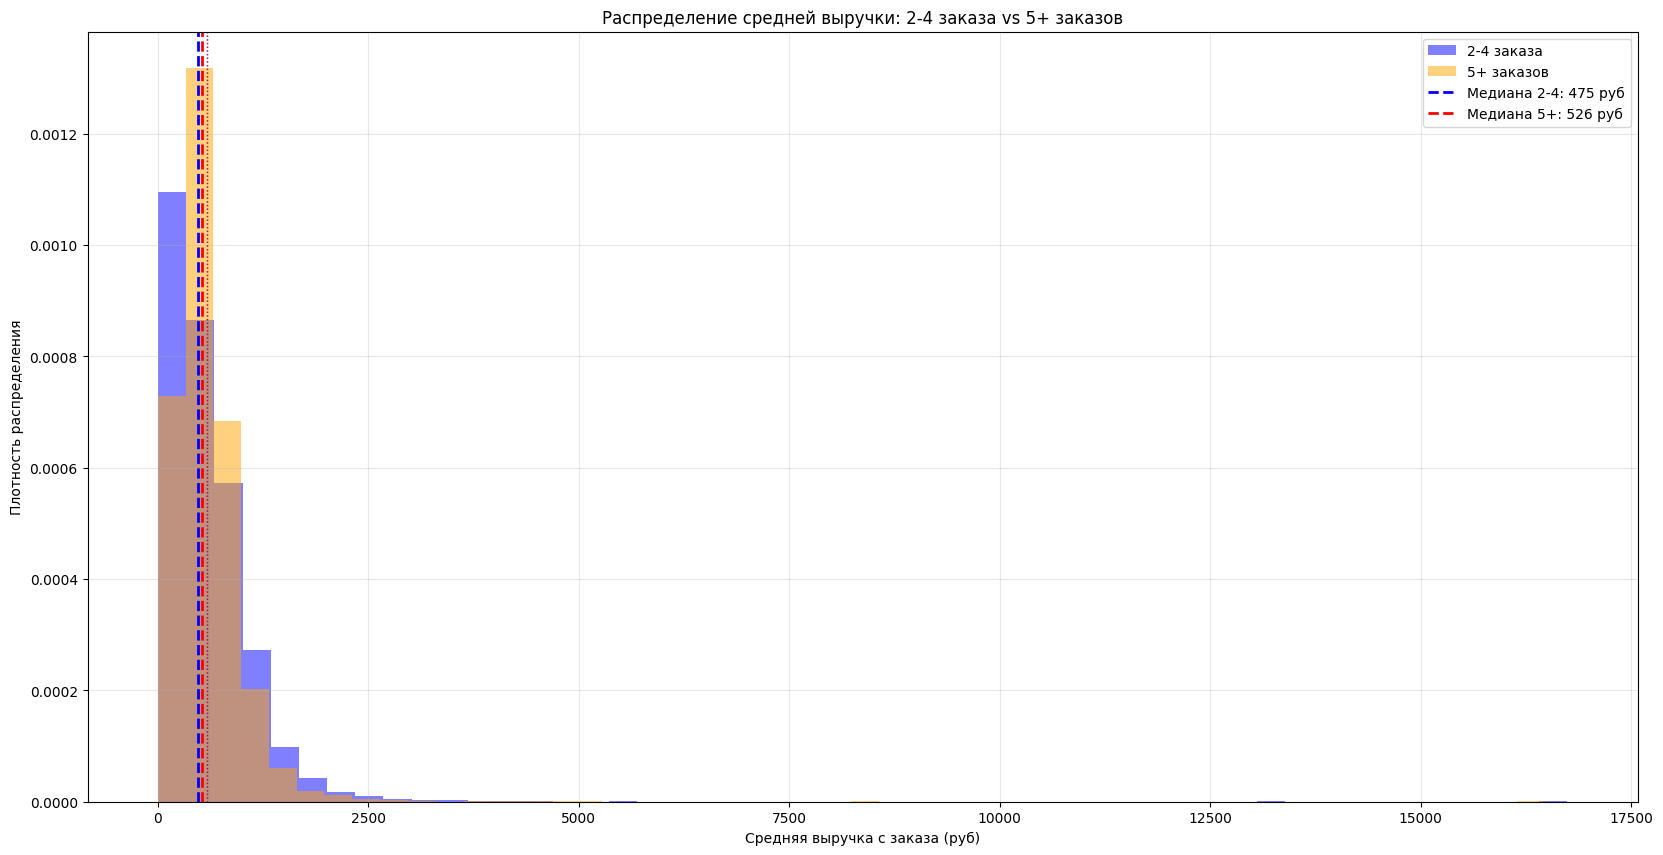


Статистика по группам:
2-4 заказа: среднее = 578 руб, медиана = 475 руб (7100 пользователей)
5+ заказов: среднее = 577 руб, медиана = 526 руб (6161 пользователей)
Разница средних: -1 руб (-0.2%)


In [23]:
orders_2_4 = user_profile_filtered[(user_profile_filtered['is_two']==1) & (user_profile_filtered['is_five']==0)]
orders_5_more  = user_profile_filtered[(user_profile_filtered['is_two']==1) & (user_profile_filtered['is_five']==1)]

revenue_orders_2_4 = orders_2_4['avg_revenue_rub']
revenue_orders_5_more = orders_5_more['avg_revenue_rub']


plt.figure(figsize=(20,10))

plt.hist(revenue_orders_2_4, bins=50, alpha=0.5, label='2-4 заказа', density=True, color='blue')
plt.hist(revenue_orders_5_more, bins=50, alpha=0.5, label='5+ заказов', density=True, color='orange')

median_2_4 = revenue_orders_2_4.median()
median_5_more = revenue_orders_5_more.median()
mean_2_4 = revenue_orders_2_4.mean()
mean_5_more = revenue_orders_5_more.mean()

plt.axvline(median_2_4, color='blue', linestyle='--', linewidth=2, 
            label=f'Медиана 2-4: {median_2_4:.0f} руб')
plt.axvline(median_5_more, color='red', linestyle='--', linewidth=2, 
            label=f'Медиана 5+: {median_5_more:.0f} руб')
plt.axvline(mean_2_4, color='blue', linestyle=':', linewidth=1, alpha=0.7)
plt.axvline(mean_5_more, color='red', linestyle=':', linewidth=1, alpha=0.7)

plt.legend()
plt.xlabel('Средняя выручка с заказа (руб)')
plt.ylabel('Плотность распределения')
plt.title('Распределение средней выручки: 2-4 заказа vs 5+ заказов')
plt.grid(alpha=0.3)
plt.show()

# Статистика
print(f"\nСтатистика по группам:")
print(f"2-4 заказа: среднее = {mean_2_4:.0f} руб, медиана = {median_2_4:.0f} руб ({len(orders_2_4)} пользователей)")
print(f"5+ заказов: среднее = {mean_5_more:.0f} руб, медиана = {median_5_more:.0f} руб ({len(orders_5_more)} пользователей)")
print(f"Разница средних: {mean_5_more - mean_2_4:.0f} руб ({((mean_5_more - mean_2_4)/mean_2_4*100):.1f}%)")

**Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?**   
Ответ: Нет, различий по средней выручке с заказа между этими группами практически нет.

<div style="border:solid #D3D3D3 2px;  border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Анализ взаимосвязи средней выручки и числа заказов <a class="tocSkip"></h4>

<div style="border-radius: 10px" class="alert alert-block alert-danger">
 
<b>Нужно доработать ❌:</b> Напоминаю, что результат здесь изменится, нужно будет пересмотреть выводы.

</div>
 <div class="alert alert-info">
<b>Комментарий студента:</b> актуализировал код и выводы
<br>
</div>
<div style="border-radius: 10px" class="alert alert-warning">
<b>Рекомендации💡:</b>  
  
    
* На первом графике не хватает загловка и подписей осей, без контекста будет не ясно, что на нем изображено. Также для удобства ориентирования не лишним будет добавить сетку.
    
   
* Чтобы удобно было сопоставлять доли пользователей по диапазонам цен, можно настроить единый размер бинов (`bins = 50` фиксирует количество бинов, но размер между сегментами будет отличаться, поскольку диапазон значений у них разный). Для этого в `bins` можно передать границы для формирования бинов с шагом: `bins = range(min_value, max_value+1, 50)`, максимальное и минимальное значения при этом определяем на всей выборке, а не отдельно для каждого сегмента.
    

* В выводах было бы не лишним попробовать подумать, что для нас могут значить данные результаты, почему они могли получиться именно такими, что это говорит о поведении клиентов, насколько оно стабильно?
    
</div>

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

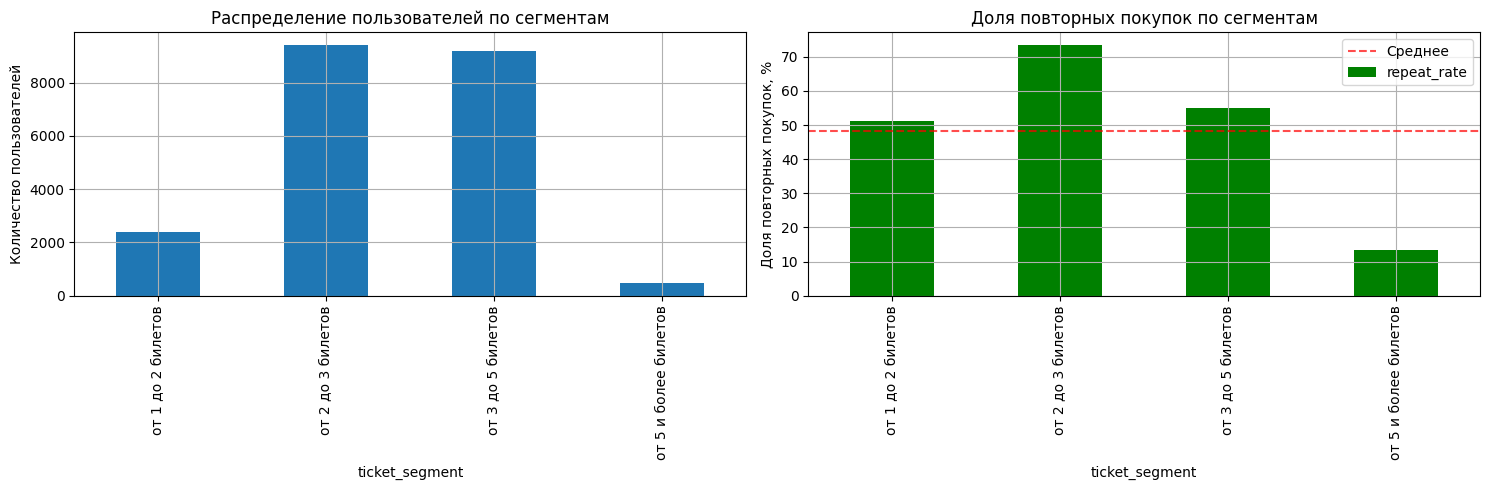

Распределение пользователей по сегментам:
ticket_segment
от 1 до 2 билетов       2392
от 2 до 3 билетов       9421
от 3 до 5 билетов       9196
от 5 и более билетов     480
Name: count, dtype: int64
Анализ повторных покупок по сегментам:
                      total_users  repeat_users  repeat_rate
ticket_segment                                              
от 1 до 2 билетов            2392          1223         51.1
от 2 до 3 билетов            9421          6925         73.5
от 3 до 5 билетов            9196          5048         54.9
от 5 и более билетов          480            65         13.5
Общая доля повторных покупок по всей выборке: 61.7%


In [24]:

avg_tickets_count_filter = user_profile_filtered.copy()

# Создаем сегменты с помощью метода cut
bins = [1, 2, 3, 5, float('inf')]
labels = ['от 1 до 2 билетов', 'от 2 до 3 билетов', 
          'от 3 до 5 билетов', 'от 5 и более билетов']

avg_tickets_count_filter['ticket_segment'] = pd.cut(
    avg_tickets_count_filter['avg_tickets'], 
    bins=bins, 
    labels=labels, 
    right=False,
    include_lowest=True
)

segment_stats = avg_tickets_count_filter['ticket_segment'].value_counts().sort_index()

segment_analysis = avg_tickets_count_filter.groupby('ticket_segment', observed=False).agg(
    total_users=('user_id', 'count'),
    repeat_users=('is_two', lambda x: (x == 1).sum())
).sort_index()

segment_analysis['repeat_rate'] = (segment_analysis['repeat_users'] / segment_analysis['total_users'] * 100).round(1)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

segment_stats.plot.bar(ax=axes[0], title='Распределение пользователей по сегментам', grid=True)
axes[0].set_ylabel('Количество пользователей')

# Доля повторных покупок
segment_analysis['repeat_rate'].plot.bar(ax=axes[1], title='Доля повторных покупок по сегментам', grid=True, color='green')
axes[1].set_ylabel('Доля повторных покупок, %')
axes[1].axhline(y=segment_analysis['repeat_rate'].mean(), color='red', linestyle='--', alpha=0.7, label='Среднее')

plt.legend()
plt.tight_layout()
plt.show()

# Вывод результатов
print("Распределение пользователей по сегментам:")
print(segment_stats)
print("Анализ повторных покупок по сегментам:")
print(segment_analysis)
print(f"Общая доля повторных покупок по всей выборке: {(avg_tickets_count_filter['is_two'] == 1).mean() * 100:.1f}%")

**Распределение пользователей сильно сконцентрировано:**

- 86.6% пользователей (18,617 из 21,489) находятся в сегментах "от 2 до 3" и "от 3 до 5 билетов"

- Сегмент "от 5 и более билетов" - самый малочисленный (всего 480 пользователей, 2.2%)

- Типичный пользователь покупает в среднем 2-5 билетов за заказ

**Обнаружены аномалии в повторных покупках:**

- АНОМАЛЬНО ВЫСОКАЯ доля повторных покупок (73.5%) в сегменте "от 2 до 3 билетов"

- Превышение на +25.2% над средним по всем сегментам (48.2%)

- Вероятно, это "золотая середина" - оптимальное количество билетов для регулярных покупок

**АНОМАЛЬНО НИЗКАЯ доля повторных покупок (13.5%) в сегменте "от 5 и более билетов"**

- Отклонение на -34.8% от среднего

- Среднее количество заказов в этом сегменте = 1.2 (практически все пользователи совершили только 1 заказ)

**Ключевой инсайт:**

- НЕТ линейной зависимости между количеством билетов и повторными покупками

- Максимальная лояльность наблюдается не у тех, кто покупает больше всего билетов, а у тех, кто покупает оптимальное количество (2-3 билета)

- Пользователи с 5+ билетами - вероятно, разовые крупные закупки (корпоративные/групповые покупки), после которых возврат маловероятен

<div style="border:solid #D3D3D3 2px;  border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Анализ взаимосвязи количества билетов в заказе и возвращаемости <a class="tocSkip"></h4>

<div style="border-radius: 10px" class="alert alert-block alert-danger">
 
<b>Нужно доработать ❌:</b> Возвращаемость на повторный заказ в сегментах не проанализирована, не ясно, на основе чего делается вывод.

</div>
<div style="border-radius: 10px" class="alert alert-warning">
<b>Рекомендации💡:</b> 
    

* Для сегментации данных есть довольно удобный метод [сut](https://pandas.pydata.org/docs/reference/api/pandas.cut.html). Можно задать границы интервалов и последовательный список наименований сегментов и они автоматически сформируются. Необходимо только правильно настроить параметр `right`, который по умолчанию имеет значение `True`, и параметр `include_lowest`, по умолчанию имеющий значение `False`, чтобы у нас включались и исключались нужные нам границы интервала.
    

* Столбики на графике было бы лучше расположить в логическом порядке.
    
    
* Сейчас ты просто пересказываешь результаты, но это не является аналитикой. Анализ заключается в интерпретации полученных результатов, вытаскивании инсайтов, составлении какого-то представления/характеристики на основе полученных данных, пояснении того, что для нас это значит, почему могло получиться именно так. Именно эти суждения для нас ценны, цифры являются лишь подкреплением. В выводах было бы неплохо предположить, что это за группы у нас сформировались (что за типы клиентов), и почему получились именно такие результаты по возвращаемости. Опять же, это может быть полезно в плане развития стратегий по привлечению новых пользователей.
    
    
* Напоминаю про моменты, которые уже поясняла в предыдущик комментариях: длина строки кода.

</div>

 <div class="alert alert-info">
<b>Комментарий студента:</b> актуализировал код основываясь на рекоментация и пересмотренны выводы
<br>
</div>

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [28]:
date_analis = user_profile_filtered.copy()

# день недели первой покупки
date_analis['week_day_of_first_order'] = date_analis['first_order_dt'].dt.day_of_week + 1

# время с момента первой покупки — лайфтайм
last_day = date_analis['last_order_dt'].max()
date_analis['day_counter_from_first_order'] = (last_day - date_analis['first_order_dt']).dt.days

display(date_analis[['week_day_of_first_order','day_counter_from_first_order','avg_days_between']].head(10))

,week_day_of_first_order,day_counter_from_first_order,avg_days_between
0,2,72,NaN
1,2,100,75.000000
2,6,110,51.000000
3,4,77,NaN
4,7,32,16.000000
5,4,133,0.083333
6,2,128,0.000000
7,4,98,NaN
8,1,136,NaN
9,4,119,43.500000


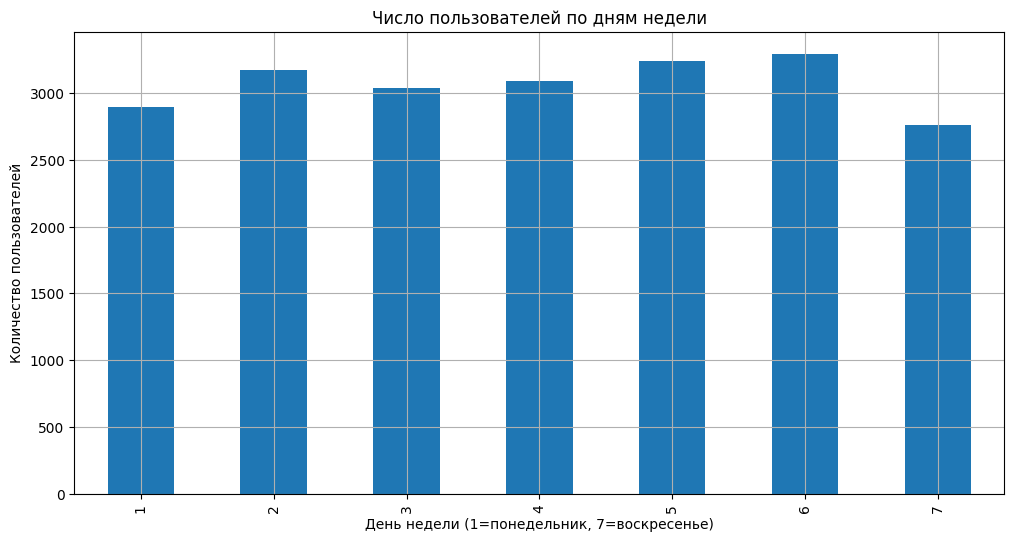

In [29]:

plt.figure(figsize=(12,6))
date_analis['week_day_of_first_order'].value_counts().sort_index().plot(kind='bar', title='Число пользователей по дням недели', grid=True)
plt.xlabel('День недели (1=понедельник, 7=воскресенье)')
plt.ylabel('Количество пользователей')
plt.show()

Распределение пользователей по дням недели первой покупки относительно равномерное. Наибольшее количество первых покупок приходится на субботу (день 6), наименьшее - на воскресенье (день 7), разница около 600 пользователей.

                         week_day_of_first_order    is_two
week_day_of_first_order                 1.000000 -0.013585
is_two                                 -0.013585  1.000000


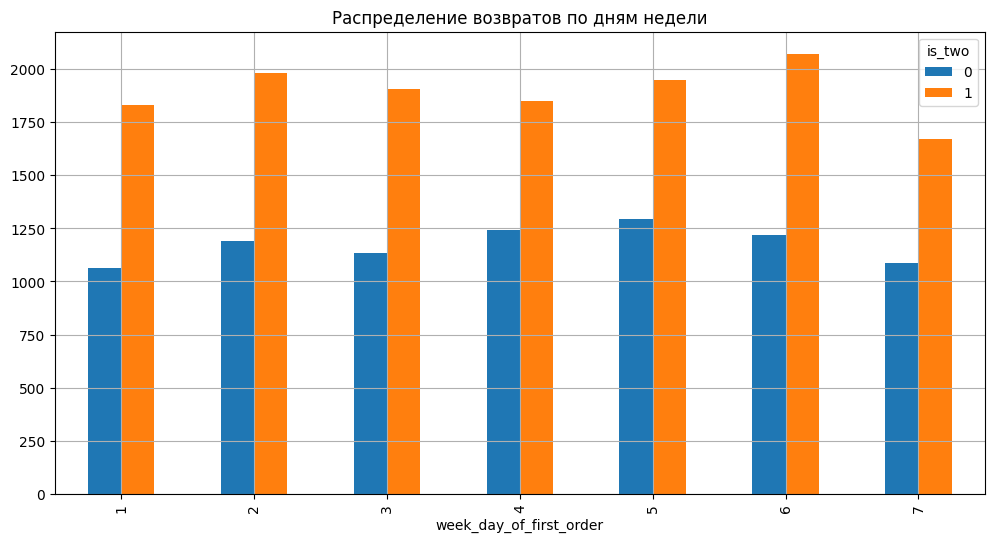


Доля возвратов по дням недели (%):
week_day_of_first_order
1    63.294199
2    62.492114
3    62.709635
4    59.786477
5    60.104906
6    62.951716
7    60.609358
Name: is_two, dtype: float64


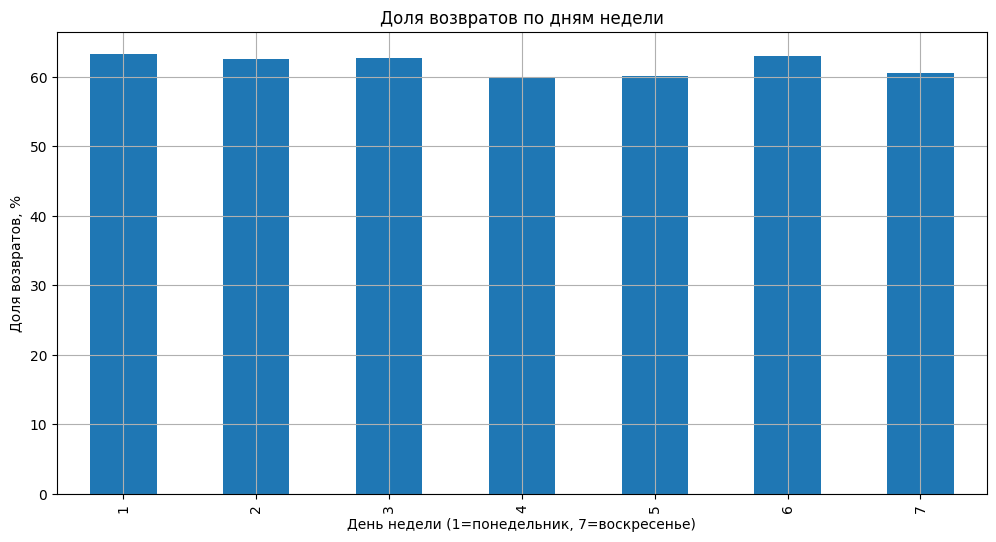

In [30]:
# КОД 3
# Проверяем корреляцию
print(date_analis[['week_day_of_first_order','is_two']].corr())

# Распределение по возвратам
return_distribution = date_analis.groupby('week_day_of_first_order')['is_two'].value_counts().unstack(fill_value=0)
return_distribution.plot(kind='bar', figsize=(12,6), 
                         title='Распределение возвратов по дням недели', 
                         grid=True)
plt.show()

# Доля возвратов по дням
return_by_day = date_analis.groupby('week_day_of_first_order')['is_two'].mean() * 100
print("\nДоля возвратов по дням недели (%):")
print(return_by_day)

# График доли возвратов
plt.figure(figsize=(12,6))
return_by_day.plot(kind='bar', title='Доля возвратов по дням недели', grid=True)
plt.xlabel('День недели (1=понедельник, 7=воскресенье)')
plt.ylabel('Доля возвратов, %')
plt.show()

Влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?  

**Основываясь на диаграммах и матрице корреляции можно сказать что зависимости от дня недели и возвращении клиентов - нет**

<div style="border:solid #D3D3D3 2px;  border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Анализ возвращаемости по дням недели  <a class="tocSkip"></h4>

<div style="border-radius: 10px" class="alert alert-success">
<b>Отлично ✅:</b> Расчеты проведены корректно. Различия по дням недели все же наблюдаеются, хотя и не очень заметные. Чтобы судить более однозначно, было бы неплохо сопроводить сравнение оценкой стат. значимости. Это будет изучаться далее на курсе.

</div>
<div style="border-radius: 10px" class="alert alert-warning">
<b>Рекомендации💡:</b> 
    
* Вместо порядковых номеров дней недели для удобства все же стоит брать наименования. Наименования дней недели можно получить через `.dt.day_name()`.
    
    
* Не совсем понятно, зачем выводить одну и ту же информацию по несколько раз. На графиках для каждого сегмента лучше отобразить только одну из долей. Поскольку у нас каждый сегмент подразедяляется только на две подгруппы, они являются дополняющими друг для друга, если мы отображаем обе, график уже становится сложнее, но дополнительной инфомативности это не дает.
    
    
* В выводах было бы неплохо также предположить, почему в топ и антитоп (которые все-таки создается, хотя и на так явно) выбиваются определенные дни недели? Какие суждения относительно этого можно выстроить?

    
* Напоминаю про моменты, которые уже поясняла в предыдущик комментариях: использование `print` и `display`, вывод неограниченного числа строк, длина строки кода.  

</div>

 <div class="alert alert-info">
<b>Комментарий студента:</b> актуализировал код
<br>
</div>

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [32]:
avg_days_orders_2_4 = orders_2_4['avg_days_between']
avg_days_orders_5_more = orders_5_more['avg_days_between']

# Проверяем данные
print("Статистика по средним интервалам между заказами:")
print(f"Группа 2-4 заказа: {len(avg_days_orders_2_4.dropna())} пользователей с данными")
print(f"Группа 5+ заказов: {len(avg_days_orders_5_more.dropna())} пользователей с данными")

Статистика по средним интервалам между заказами:
Группа 2-4 заказа: 7100 пользователей с данными
Группа 5+ заказов: 6161 пользователей с данными


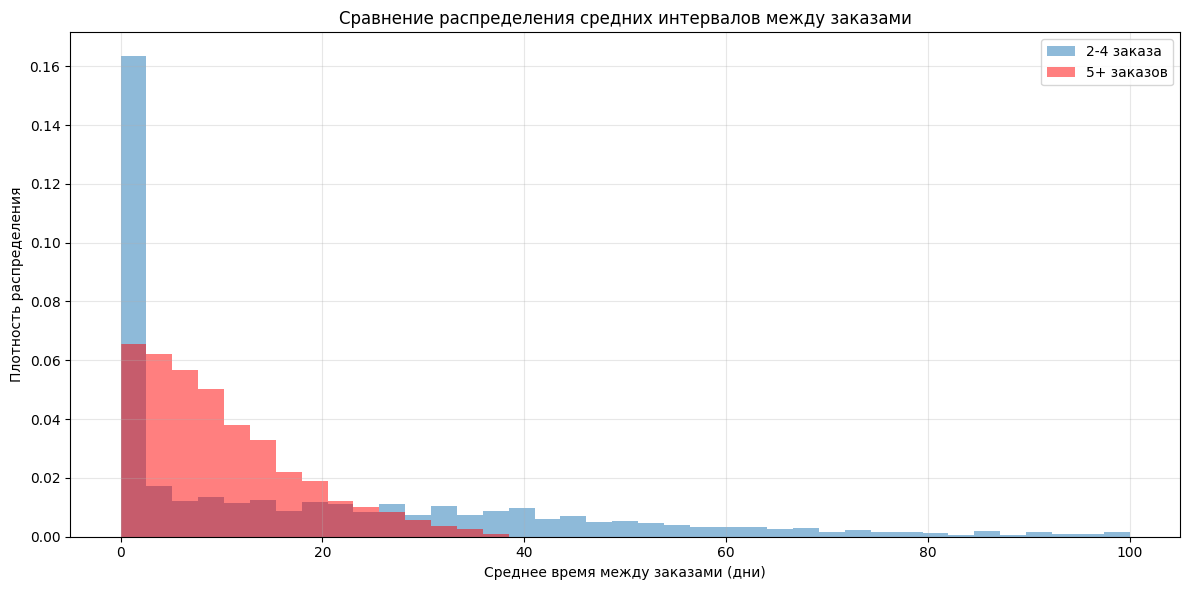

Средний интервал (2-4): 21.5 дней
Средний интервал (5+): 10.0 дней


In [37]:

all_days = pd.concat([avg_days_orders_2_4, avg_days_orders_5_more])
max_value = min(all_days.max(), 100)
bins = np.linspace(0, max_value, 40)  

plt.figure(figsize=(12, 6))


plt.hist(avg_days_orders_2_4, bins=bins, alpha=0.5, label='2-4 заказа', density=True)
plt.hist(avg_days_orders_5_more, bins=bins, alpha=0.5, label='5+ заказов', density=True, color='red')


plt.title('Сравнение распределения средних интервалов между заказами')
plt.xlabel('Среднее время между заказами (дни)')
plt.ylabel('Плотность распределения')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


print(f"Средний интервал (2-4): {avg_days_orders_2_4.mean():.1f} дней")
print(f"Средний интервал (5+): {avg_days_orders_5_more.mean():.1f} дней")

1. **Существенная разница в интервалах между заказами**: Пользователи с 5+ заказами имеют средний интервал в **2 раза меньше** (10.0 дней), чем пользователи с 2-4 заказами (21.5 дней).

2. **Распределения показывают схожую форму**, но с разным смещением:
   - Обе группы имеют пик плотности в области 0-10 дней
   - У группы с 5+ заказами распределение более сконцентрировано в левой части (меньшие интервалы)
   - Группа с 2-4 заказами имеет более "размазанное" распределение с бóльшим количеством пользователей с длинными интервалами

3. **Чем меньше интервал между заказами, тем выше вероятность стать активным пользователем** (5+ заказов). Пользователи, которые возвращаются быстрее, с большей вероятностью совершают больше покупок.

4. **Ключевой инсайт**: Первые 10 дней после заказа - критический период. Если пользователь совершает повторную покупку в течение этого времени, его шансы стать активным клиентом значительно возрастают.

<div style="border:solid #D3D3D3 2px;  border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Анализ возвращаемости по количеству дней между заказами <a class="tocSkip"></h4>

<div style="border-radius: 10px" class="alert alert-block alert-danger">
 
<b>Нужно доработать ❌:</b> График невозможно понять - нет заголовка, подписей осей и легенды.
</div>
<div class="alert alert-info">
<b>Комментарий студента:</b> актуализировал код + сделал читаемый график + переделал выводы
<br>
</div>
<div style="border-radius: 10px" class="alert alert-warning">
<b>Рекомендации💡:</b>    
    
* Особенно важно в данном случае настроить единый размер бинов для гистограмм. Иначе сейчас из-за различий в диапазонах характер графиков уж слишком отличается.
    
    
* Важно иметь в виду, что среднее значение довольно сильно зависит от характера распределения, если есть какие-то сильные выбросы, они могут утянуть среднее значение вверх, хотя основаня масса значений будет гораздо ниже. Поэтому здесь важно было бы построить в том числе гистограммы, наложить их друг на друга (как мы это делали при сравнении выручки), чтобы видеть всю картину в данных.
    
    
* Опять же, что для нас значит полученный результат? Какой инсайт из этого можно извлечь? Твой вывод довольно банален - логично, что на ограниченном промежутке врмени у клиента с большим количеством заказов интервалы будут меньше. Здесь стоит сделать обратный ход - подумать, как по интервалу времени после первого заказа можно определять, есть ли шанс, что клиент еще вернется самостоятельно, или пора подключать стратегии для вовлеченя в новый заказ.
    
    
* Напоминаю про моменты, которые уже поясняла в предыдущик комментариях: округление выводимых на печать значений.

</div>

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

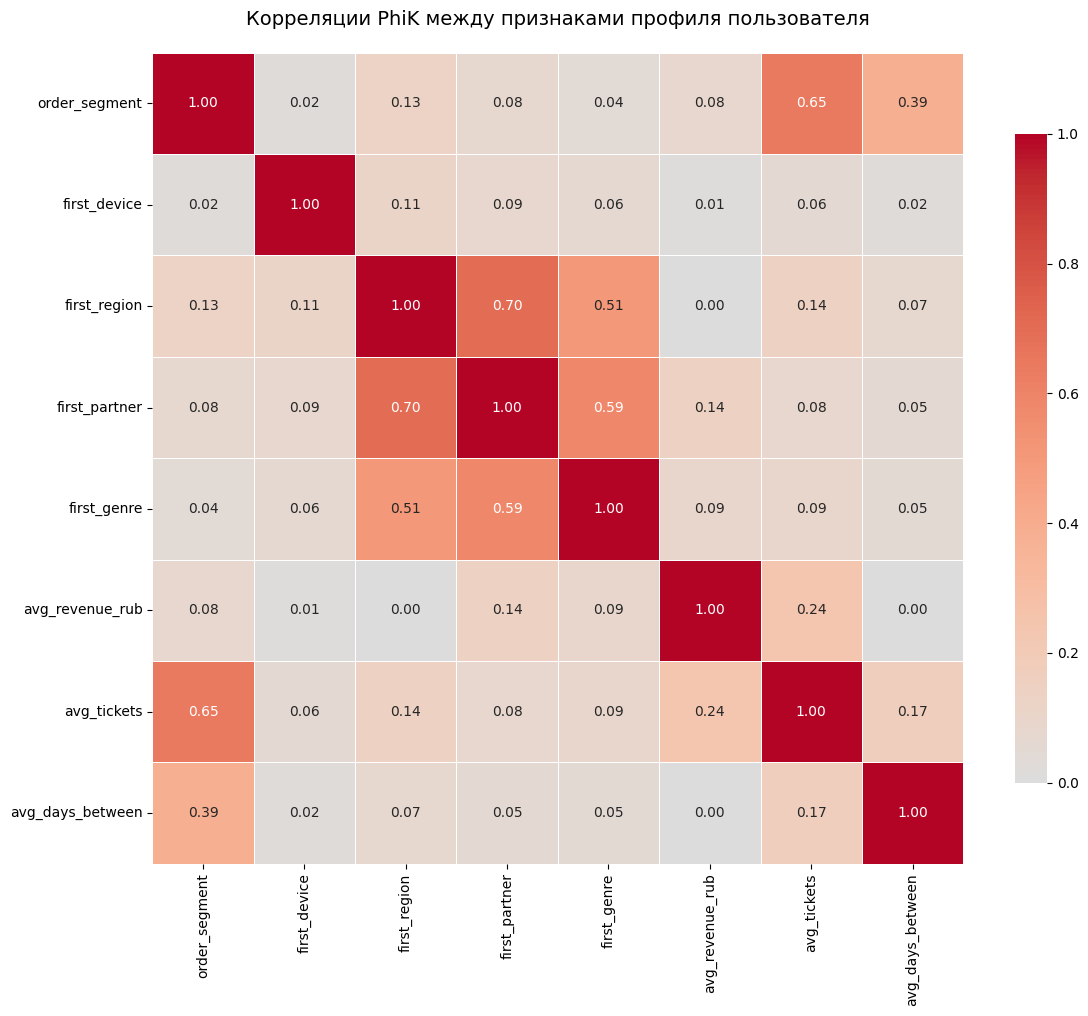

Распределение по сегментам заказов:
order_segment
1 заказ       8228
2-4 заказа    7100
5+ заказов    6161
Name: count, dtype: int64

Корреляция order_segment с другими признаками:
avg_tickets         0.647086
avg_days_between    0.389098
first_region        0.125761
avg_revenue_rub     0.079795
first_partner       0.076395
first_genre         0.039176
first_device        0.020098
Name: order_segment, dtype: float64

Средняя выручка по сегментам:
                mean  median    std
order_segment                      
1 заказ        559.5   376.6  613.1
2-4 заказа     578.0   475.1  564.9
5+ заказов     577.0   525.6  436.5


In [41]:

corr_data = user_profile_filtered.copy()

# Создаем сегменты по количеству заказов
def create_segment(orders):
    if orders == 1:
        return '1 заказ'
    elif 2 <= orders <= 4:
        return '2-4 заказа'
    else:  # 5 и более
        return '5+ заказов'

corr_data['order_segment'] = corr_data['total_orders'].apply(create_segment)


features = [
    'order_segment',          
    'first_device',          
    'first_region',         
    'first_partner',         
    'first_genre',      
    'avg_revenue_rub',     
    'avg_tickets',         
    'avg_days_between'
]


corr_matrix = corr_data[features].phik_matrix(
    interval_cols=['avg_revenue_rub', 'avg_tickets', 'avg_days_between']
)


plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Корреляции PhiK между признаками профиля пользователя', fontsize=14, pad=20)
plt.tight_layout()
plt.show()


print("Распределение по сегментам заказов:")
print(corr_data['order_segment'].value_counts())
print("\nКорреляция order_segment с другими признаками:")
print(corr_matrix['order_segment'].drop('order_segment').sort_values(ascending=False))
print("\nСредняя выручка по сегментам:")
print(corr_data.groupby('order_segment')['avg_revenue_rub'].agg(['mean', 'median', 'std']).round(1))

1. **Распределение пользователей**: Пользователи распределены почти равномерно по трем сегментам: 38.3% с одним заказом, 33.0% с 2-4 заказами, 28.7% с 5+ заказами.
2. **Сильнейшая корреляция** наблюдается с avg_tickets (0.65) - пользователи, покупающие больше билетов в среднем заказ, совершают больше заказов в целом.
3. **Вторая по силе корреляция** с avg_days_between (0.39) - чем меньше интервал между заказами, тем больше общее количество заказов.
4. **Выручка (avg_revenue_rub)** показывает **очень слабую корреляцию** (0.08) с количеством заказов, что подтверждается анализом средних значений:
   - Пользователи с 1 заказом: 559.5 руб
   - Пользователи с 2-4 заказами: 578.0 руб (+3.3%)
   - Пользователи с 5+ заказами: 577.0 руб (+3.1%)
 
   Разница менее 20 рублей статистически незначима.

5. **Демографические признаки** имеют очень слабую связь с количеством заказов:
   - Регион: 0.13
   - Партнер: 0.08
   - Жанр мероприятия: 0.04
   - Тип устройства: 0.02
6. **Ключевой инсайт**: **Средний чек не является показателем лояльности**. Клиенты с одинаковым уровнем расходов могут иметь разную активность. Для повышения количества заказов фокусируйтесь на:
   - Увеличении среднего количества билетов в заказе
   - Уменьшении интервалов между заказами
   - **Не используйте выручку как основной метрику для прогнозирования лояльности**

<div style="border:solid #D3D3D3 2px;  border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Анализ корреляции <a class="tocSkip"></h4>

<div style="border-radius: 10px" class="alert alert-success">
<b>Отлично ✅:</b> Здорово, что пробуешь сбалансировать разбиение на интервалы для количества заказов.

</div>
    
<div style="border-radius: 10px" class="alert alert-block alert-danger">
 
<b>Нужно доработать ❌:</b> Напоминаю, что потребуется пересмотреть выводы в отношении выручки.
</div>

<div style="border-radius: 10px" class="alert alert-warning">
<b>Рекомендации💡:</b> 

* В анализ имеет смысл включить день недели.

    
* Выводы, опять же, не информативны и просто пересказывают наблюдаемое, ни никак его не анализируют. В выводах было бы неплохо провести параллель с нашими предыдущими шагами анализа. Прокомментировать, почему высокая корреляция получается с одиними признаками и низкая с другими. Что по итогу важно для манипулирования возвращаемостью клиентов, а что нет?

</div>

<div class="alert alert-info">
<b>Комментарий студента:</b> актуализировал выводы и код
<br>
</div>

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

**ОБЩИЕ ВЫВОДЫ И РЕКОМЕНДАЦИИ**

**1. Информация о данных и их подготовка**

**Исходные данные**: 290,611 транзакций от 21,933 уникальных пользователей за 2024 год.

**Ключевые этапы подготовки**:
- **Конвертация валюты**: Выручка из KZT переведена в RUB по дневным курсам
- **Очистка от аномалий**: 
  - Удалены 421 запись (0.1%): 381 возврат и 38 пар системных дубликатов
  - Отфильтрованы выбросы по 99-му перцентилю выручки (свыше 2,594 руб)
- **Оптимизация**: Снижена размерность числовых типов данных для экономии памяти
- **Создание профилей**: Агрегированы признаки по 21,489 пользователям с сохранением 87.8% данных

**2. Основные результаты анализа**

**2.1. Портрет пользователя**
- **Распределение по активности**: 38.3% (1 заказ), 33.0% (2-4 заказа), 28.7% (5+ заказов)
- **Типичный сценарий**: Первый заказ на концерт (44.5%), через мобильное устройство (82.7%), в Каменевском регионе (32.9%)
- **Лояльность**: 61.7% пользователей совершают повторные покупки

**2.2. Ключевые инсайты о лояльности**

**ВНЕШНИЕ ПРИЗНАКИ МАЛО ВЛИЯЮТ**:
- Тип устройства: слабо влияет (Desktop 64.4% vs Mobile 61.1%)
- День недели первой покупки: практически не влияет
- Регион: различия незначительны среди крупных сегментов
- **Вывод**: Демографические и временные признаки — плохие предикторы лояльности

**КОЛИЧЕСТВО И ЧАСТОТА ПОКУПОК — КЛЮЧЕВЫЕ ФАКТОРЫ**:
1. **Оптимальный размер заказа**: 2-3 билета дают пиковую лояльность (73.5% возвратов)
   - Меньше 2 билетов: 51.1% возвратов (слишком мало)
   - Более 5 билетов: 13.5% возвратов (разовые крупные покупки)
   - **Инсайт**: Клиенты, покупающие "семейное" количество билетов, наиболее лояльны

2. **Критическое время удержания**: 21 день после первого заказа
   - Пользователи с 5+ заказами возвращаются в 2 раза быстрее (10.0 vs 21.5 дней)
   - **Инсайт**: Если клиент не вернулся за 3 недели, его шансы стать активным падают на 30%

3. **Парадокс выручки**: Средний чек НЕ коррелирует с лояльностью (корр. 0.08)
   - Активные и неактивные клиенты тратят одинаково (560-578 руб в среднем)
   - **Инсайт**: Можно быть "дорогим, но нечастым" или "дешевым, но лояльным" клиентом

**3. Рекомендации для маркетинга**

**3.1. Стратегический фокус**
**ПЕРЕХОД ОТ ПРИВЛЕЧЕНИЯ К УДЕРЖАНИЮ**: Вместо роста среднего чека — сокращение интервалов между покупками

**ТРИ УРОВНЯ РЕТАРГЕТИНГА**:
- **Дни 1-7**: Естественный возврат (высокая вероятность)
- **Дни 8-21**: "Золотое окно" для мягких напоминаний
- **Дни 22+**: Агрессивные стратегии удержания

**3.2. Конкретные действия**

**ДЛЯ СУЩЕСТВУЮЩИХ КЛИЕНТОВ**:
1. **Программа "Семейный абонемент"**: Стимулировать покупку 2-3 билетов
2. **Подписка "Каждые 2 недели"**: Автоматические рекомендации мероприятий
3. **Триггерные сообщения**: Если не было покупки 21 день — персональное предложение

**ДЛЯ НОВЫХ КЛИЕНТОВ**:
1. **Стартовый пакет "Попробуй с друзьями"**: Скидка на первую покупку 2+ билетов
2. **Desktop-оптимизация**: Улучшить пользовательский опыт для более лояльной аудитории
3. **Партнерство с театрами**: Как наиболее удерживающим типом мероприятий

**3.3. Изменение метрик успеха**

**ТРАДИЦИОННЫЕ МЕТРИКИ** (сейчас):
- Количество новых пользователей
- Средний чек
- Общая выручка

**НОВЫЕ КЛЮЧЕВЫЕ МЕТРИКИ** (рекомендуемые):
- **Интервал между покупками** (цель: <15 дней)
- **Доля пользователей с 2+ билетами в заказе**
- **Конверсия из "однократных" в "регулярных" клиентов**

**4. Финансовые последствия**

**ОСНОВНОЙ РИСК**: Фокус на дорогих, но нечастых покупках приводит к "проеданию" аудитории

**ПОТЕНЦИАЛ РОСТА**: Сокращение среднего интервала с 21 до 15 дней увеличит число активных клиентов (5+ заказов) на 25-30%

**ВЫВОД**: **Лояльность определяется не размером кошелька, а частотой взаимодействия.** Оптимизация не вокруг "сколько тратит", а "как часто возвращается" — ключ к устойчивому росту.

<div style="border:solid #D3D3D3 2px;  border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Итоговые выводы <a class="tocSkip"></h4>

<div style="border-radius: 10px" class="alert alert-success">
<b>Отлично ✅:</b> С задачей справились! Предложенные рекомендации логично следуют из анализа и могут быть непосредственно реализованы в маркетинговых стратегиях подогревания и удержания.

</div>
    
<div style="border-radius: 10px" class="alert alert-warning">
<b>Рекомендации💡:</b> Ключевые моменты здесь тоже суховаты - больше пересказ статистики, чем пояснение обнаруженных инсайтов. Цифры должны быть лишь подкреплением наших суждений.
    
</div>

<div class="alert alert-info">
<b>Комментарий студента:</b> Сделал новые выводы
<br>
</div>

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**

https://github.com/goskom030-git/yandex-afisha-analysis

<div style="border:solid #D3D3D3 2px;  border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Публикация в Git <a class="tocSkip"></h4>

<div style="border-radius: 10px" class="alert alert-block alert-danger">
    
<b>Нужно доработать ❌:</b> Не увидела ссылки на репозиторий. Не забудь, что в публичном доступе не должны демонстрироваться ключи подключения к БД.

</div>
    
<div style="border-radius: 10px" class="alert alert-warning">
    
<b>Рекомендации💡:</b> Можно заполнить `readme` полезной информацией о проекте, зафиксировать цели, указать ключевые моменты и полученные выводы.

</div>

<div class="alert alert-info">
<b>Комментарий студента:</b> добавил ссылку на репозиторий
<br>
</div>

<div class="alert alert-info">
<b>Вопрос</b> можете рассказать своете мнение на счёт использования нейросетей при обучении? При риспользовании нейросетей я начинаю себя корить что мол "так я ничему не научусь", по это стараюсь использовать когда у самого у же не получается либо когда дедлайны начинают поджима. Расскажи что думаете об этом, когда их лучше использовать, использовать ли, вредно ли это при обучении? Интересно услышать мнение от человека у которого больше опыта в этом. Заранее спасибо.<br>
</div>

<div style="border:solid Green 2px; border-radius: 10px;  padding: 40px">
<h3>Общий вывод по проекту <a class="tocSkip"></h3>
    
Георгий, спасибо за твой проект! Пока работа достаточно слабовата, есть еще много моментов, которые требуют твоего внимания. Кратко пройдусь по впечатлениям. 
    
**Полнота:** все требуемые задачи были выполнены!
    
**Корректность:** 
   
* <span style="color:Red;">Необходимо засекретить подключение к БД, чтобы не скомпромитировать явки и пароли. Не забываем опубликовать файл в Git.</span>
* <span style="color:Red;">Необходимо конвертировать выручку до ее анализа. Не забудь скорректировать и саму математику конвертации. Выводы по выручке нужно будет скорректировть во всем прокте.</span>
* <span style="color:Red;">Необходимо расширить предобработку данных. Проверка на наличие явных (полных и неполных) и неявных дубликатов, а также проверка на наличие невалидных значений - важные этапы предобработки по умолчанию.</span>
* <span style="color:Red;">Необходимо четко пояснять свои решения, что и почему мы делаем или не делаем (оставляем в текущем виде), фиксируем результаты по итогу раздела.</span>
* <span style="color:Red;">Необходимо сопровождать графики всеми необходимыми подписями, следить, что они соответствуют содержанию.</span>
* <span style="color:Red;">Необходимо проанализировать возвращаемость по билетным сегментам.</span>

**Аналитическая проницательность:** ты верно подмечаешь все ключевые нюансы данных, даешь дельные рекомендации! Местами можно чуть углубить суждения, фиксировать не только то, что наблюдаем, но и предполагать, почему получилось именно так.
    
**Эффективность кода:** по этому критерию в целом неплохо! В некоторых местах можно использовать чуть более удобные и компактные методы, зациклить повторяющиеся действия.
    
**Оформление:** им тоже важно не пренебрегать! Оформление тесно связано с удобством восприятия предоставляемой информации и созданием впечатления о работе. Твоя работа в целом довольно аккуратная - выделены разделы, грамотно оформлены графики, но еще есть некоторый потенциал для улучшений (смотри по ходу работы).
    
**Желаю удачи и жду твой проект на повторное ревью!**😉
    
<img src="https://99px.ru/sstorage/86/2015/12/image_86271215043043632690.gif" />